<a href="https://colab.research.google.com/github/Angelicogfa/analise_fraude/blob/master/02-analise_exploratoria_dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install prince -U -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.8/417.8 kB 5.4 MB/s eta 0:00:00


# Análise explorátoria dos dados de treino/teste

https://www.kaggle.com/datasets/computingvictor/transactions-fraud-datasets

In [2]:
import os
import shutil
import folium
import prince
import tabulate
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import plotly.express as px
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

from warnings import filterwarnings
filterwarnings('ignore')

Carregar os dados pré-processados obtidos do repositorio do kaggle

In [3]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  # shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_notarget.parquet'  ,'/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_train_test.parquet','/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_validation.parquet','/content/datasets/')

Mounted at /content/drive


Carregar os dados de treino e teste

In [4]:
df = pd.concat([pd.read_parquet('./datasets/df_train_test.parquet', engine='pyarrow'), pd.read_parquet('./datasets/df_validation.parquet', engine='pyarrow')])
df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,...,Debit (Prepaid),5497590243197280,07/2022,306,YES,2,55.0,05/2008,2008,No
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,...,Credit,5175842699412235,12/2024,438,YES,1,9100.0,09/2005,2015,No
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,...,Debit,5874992802287595,05/2020,256,YES,1,14802.0,01/2006,2008,No
3,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,...,Debit,4354185735186651,01/2020,120,YES,1,19113.0,07/2009,2014,No
4,7475333,2010-01-01 00:07:00,1807,165,4.81,Swipe Transaction,20519,Bronx,NY,10464.0,...,Debit (Prepaid),5207231566469664,03/2014,198,YES,1,89.0,01/2008,2015,No


In [5]:
df.shape

(8914963, 38)

In [6]:
df['id'] = df['id'].astype(str)
df['client_id'] = df['client_id'].astype(str)
df['card_id'] = df['card_id'].astype(str)
df['merchant_id'] = df['merchant_id'].astype(str)
df['zip'] = df['zip'].astype(str)
df['card_number'] = df['card_number'].astype(str)
df['cvv'] = df['cvv'].astype(str)
df['birth_year'] = df['birth_year'].astype(str)
df['birth_month'] = df['birth_month'].astype(str)


1. **id**: Identificador único da transação.
2. **date**: Data em que a transação foi realizada.
3. **client_id**: Identificador único do cliente.
4. **card_id**: Identificador único do cartão utilizado na transação.
5. **amount**: Valor da transação.
6. **use_chip**: Indicador se a transação foi efetuada com o uso de chip (sim/não).
7. **merchant_id**: Identificador do comerciante onde a transação foi realizada.
8. **merchant_city**: Cidade onde está localizado o comerciante.
9. **merchant_state**: Estado onde está localizado o comerciante.
10. **zip**: Código postal do local do comerciante.
11. **mcc**: Código de Categoria do Comerciante, que indica o tipo de negócio ou setor do comerciante.
12. **errors**: Indicador de erros ocorridos durante a transação.
13. **description**: Descrição ou comentário associado à transação.
14. **target**: Indicador se a transação foi fraudulenta (Yes) ou não (No).
15. **current_age**: Idade atual do cliente.
16. **retirement_age**: Idade de aposentadoria do cliente.
17. **birth_year**: Ano de nascimento do cliente.
18. **birth_month**: Mês de nascimento do cliente.
19. **gender**: Gênero do cliente.
20. **address**: Endereço residencial do cliente.
21. **latitude**: Latitude do endereço do cliente.
22. **longitude**: Longitude do endereço do cliente.
23. **per_capita_income**: Renda per capita do cliente ou região.
24. **yearly_income**: Renda anual do cliente.
25. **total_debt**: Dívida total do cliente.
26. **credit_score**: Pontuação de crédito do cliente.
27. **num_credit_cards**: Número de cartões de crédito que o cliente possui.
28. **card_brand**: Bandeira do cartão utilizado na transação (Visa, Mastercard, etc.).
29. **card_type**: Tipo do cartão (crédito, débito, etc.).
30. **card_number**: Número do cartão utilizado na transação.
31. **expires**: Data de expiração do cartão.
32. **cvv**: Código de segurança do cartão.
33. **has_chip**: Indicador se o cartão possui chip (sim/não).
34. **num_cards_issued**: Número de cartões emitidos para o cliente.
35. **credit_limit**: Limite de crédito do cartão.
36. **acct_open_date**: Data de abertura da conta do cliente.
37. **year_pin_last_cha**: Ano da última alteração do PIN do cartão.
38. **card_on_dark_web**: Indicador se o cartão foi encontrado em listas de venda na dark web.

In [7]:
def get_outliers(df, column, min_zero = True):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  if min_zero:
    lower_bound = lower_bound if lower_bound >= 0 else 0
  upper_bound = Q3 + 1.5 * IQR
  if min_zero:
    upper_bound = upper_bound if upper_bound >= 0 else 0

  return lower_bound, upper_bound

In [8]:
def plot_hist_box(df_, var):
  data = df[var]

  fig = plt.figure(figsize=(15,4))
  ax1 = fig.add_subplot(1, 3, 1)
  ax1.set_title('Histograma')
  sns.histplot(data, kde=True, ax = ax1)
  ax1.set_xlabel(var)
  ax1.tick_params(axis='x', rotation=90)
  ax1.set_ylabel('Frequência')

  ax2 = fig.add_subplot(1, 3, 2)
  ax2.set_title('Boxplot')
  sns.boxplot(data, ax=ax2)
  ax2.set_ylabel('Frequência')

  ax3 = fig.add_subplot(1, 3, 3)
  ax3.set_title('QQ-plot')
  sm.qqplot(data, line='s', ax=ax3)

  plt.suptitle(f'{var}')
  plt.tight_layout()
  plt.show()

In [9]:
def descritiva(df_, var, vresp: str, max_classes=5, map_target: dict|None = None):
    df = df_[[var, vresp]].copy()

    if df[var].dtype in [np.float64, np.int64]:
      if df[var].nunique()>max_classes:
          df[var] = pd.qcut(df[var], max_classes, duplicates='drop')

    if map_target is not None:
      df[vresp] = df[vresp].map(map_target)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1 = sns.countplot(data=df, x=var, palette='viridis', alpha=0.5, ax=ax1)
    ax1.set_ylabel('Frequência', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    for p in ax1.patches:
        ax1.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

    ax2 = ax1.twinx()

    sns.pointplot(data=df, y=vresp, x=var, ax=ax2)
    ax2.set_ylabel(vresp, color='red')

    ax1.set_zorder(2)
    ax1.patch.set_visible(False)  # Tornar o fundo do eixo 1 transparente

    # Exibir o gráfico
    plt.show()
    del df

## Análise Temporal

Vamos analisar os dados com base na caracteristica tempo a fim de entender as caracteristicas das transações

### Análise diaria

In [10]:
df_time_day = pd.DataFrame()
df_time_day['day'] = df['date'].dt.to_period('D')
df_time_day['target'] = df['target'].apply(lambda x: 1 if x == 'Yes' else 0)
df_time_day['amount'] = df['amount']
df_time_day.head()

,day,target,amount
0,2010-01-01,0,-77.00
1,2010-01-01,0,14.57
2,2010-01-01,0,80.00
3,2010-01-01,0,46.41
4,2010-01-01,0,4.81


In [11]:
pd.pivot_table(
    df.assign(year=df['date'].dt.to_period('Y'), negative=df['amount']<0) \
    .groupby(by='year')['negative'].value_counts().reset_index(), index='year', columns='negative', values='count') \
    .reset_index() \
    .rename(columns={'year': 'Ano', False: 'Transações com Valores Positivos', True: 'Transações com Valores Negativos'}) \
    .assign(Total=lambda x: x['Transações com Valores Positivos'] + x['Transações com Valores Negativos']) \
    .assign(ProporcaoNegativa=lambda x: x['Transações com Valores Negativos']/x['Total']) \
    .style.format({'ProporcaoNegativa': '{:.2%}'})

negative,Ano,Transações com Valores Positivos,Transações com Valores Negativos,Total,ProporcaoNegativa
0,2010,788453.000000,43076.000000,831529.000000,5.18%
1,2011,819342.000000,44086.000000,863428.000000,5.11%
2,2012,841269.000000,44152.000000,885421.000000,4.99%
3,2013,862036.000000,45268.000000,907304.000000,4.99%
4,2014,870254.000000,44819.000000,915073.000000,4.90%
5,2015,884494.000000,45730.000000,930224.000000,4.92%
6,2016,886859.000000,45903.000000,932762.000000,4.92%
7,2017,891214.000000,46070.000000,937284.000000,4.92%
8,2018,889094.000000,45505.000000,934599.000000,4.87%
9,2019,739169.000000,38170.000000,777339.000000,4.91%


In [12]:
df.query('amount >= 0', inplace=True)

In [13]:
df.shape

(8472184, 38)

In [14]:
df_time_day = pd.DataFrame()
df_time_day['day'] = df['date'].dt.to_period('D')
df_time_day['target'] = df['target'].apply(lambda x: 1 if x == 'Yes' else 0)
df_time_day['amount'] = df['amount']
df_time_day.head()

,day,target,amount
1,2010-01-01,0,14.57
2,2010-01-01,0,80.00
3,2010-01-01,0,46.41
4,2010-01-01,0,4.81
5,2010-01-01,0,26.46


In [15]:
df_transactions_day = df_time_day.groupby(by='day').agg({'amount': ['sum', 'count'], 'target': 'sum'}).reset_index()
df_transactions_day.columns = ['day', 'amount', 'transactions', 'total_frauds']
df_transactions_day['mean_amount'] = (df_transactions_day['amount'] / df_transactions_day['transactions']).round(2)
df_transactions_day['has_fraud'] = df_transactions_day['total_frauds'] > 0
df_transactions_day.head()

,day,amount,transactions,total_frauds,mean_amount,has_fraud
0,2010-01-01,99747.21,2191,1,45.53,True
1,2010-01-02,100189.82,1889,0,53.04,False
2,2010-01-03,102155.91,2104,1,48.55,True
3,2010-01-04,100967.68,2113,2,47.78,True
4,2010-01-05,111492.52,2140,1,52.10,True


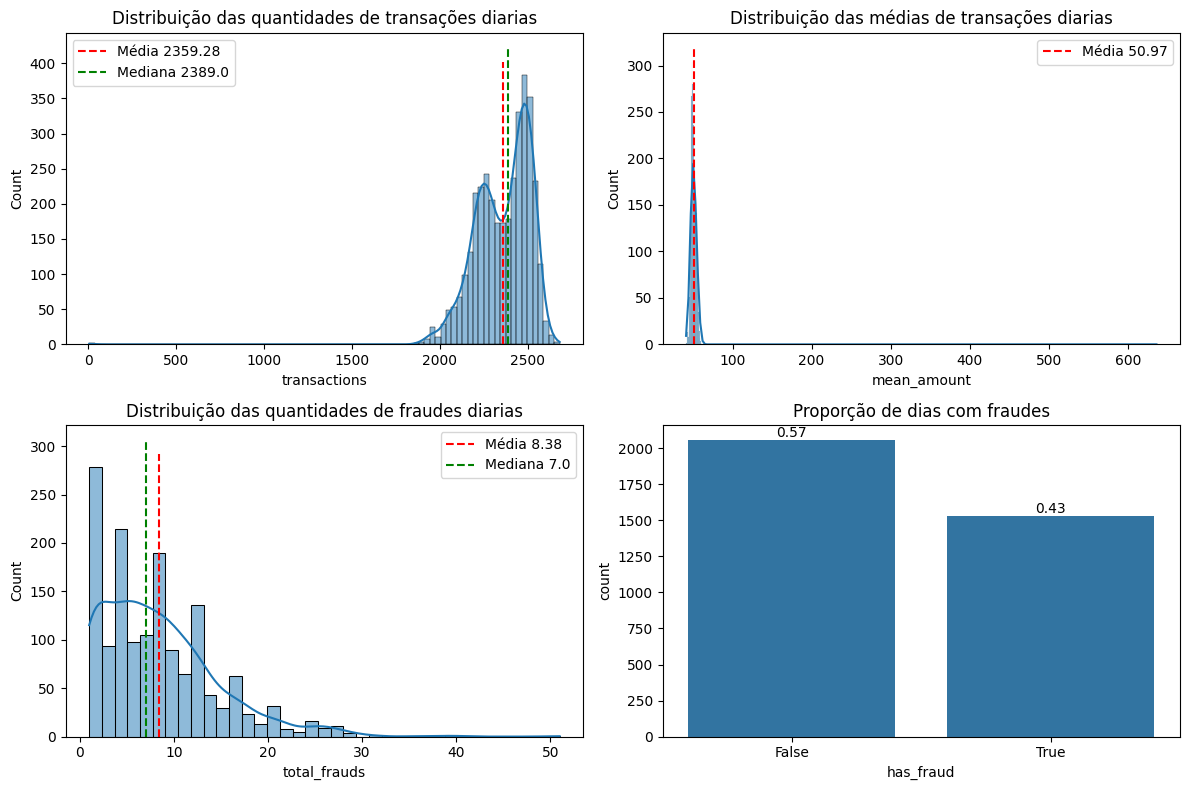

In [16]:
plt.figure(figsize=(12, 8))
plt.subplot(221)

plt.title('Distribuição das quantidades de transações diarias')
ax = sns.histplot(df_transactions_day['transactions'], kde=True)
ax.vlines(df_transactions_day['transactions'].mean(), 0, ax.get_ylim()[1], color='red', linestyles='dashed', label=f'Média {round(df_transactions_day["transactions"].mean(), 2)}')
ax.vlines(df_transactions_day['transactions'].median(), 0, ax.get_ylim()[1], color='green', linestyles='dashed', label=f'Mediana {round(df_transactions_day["transactions"].median(), 2)}')
ax.legend()

plt.subplot(222)
plt.title('Distribuição das médias de transações diarias')
ax = sns.histplot(df_transactions_day['mean_amount'], kde=True)
ax.vlines(df_transactions_day['mean_amount'].mean(), 0, ax.get_ylim()[1], color='red', linestyles='dashed', label=f'Média {round(df_transactions_day["mean_amount"].mean(), 2)}' )
ax.legend()

plt.subplot(223)
plt.title('Distribuição das quantidades de fraudes diarias')
ax = sns.histplot(df_transactions_day.query('total_frauds > 0')['total_frauds'], kde=True)
ax.vlines(df_transactions_day.query('total_frauds > 0')['total_frauds'].mean(), 0, ax.get_ylim()[1], color='red', linestyles='dashed', label=f'Média {round(df_transactions_day.query("total_frauds > 0")["total_frauds"].mean(), 2)}')
ax.vlines(df_transactions_day.query('total_frauds > 0')['total_frauds'].median(), 0, ax.get_ylim()[1], color='green', linestyles='dashed', label=f'Mediana {round(df_transactions_day.query("total_frauds > 0")["total_frauds"].median(), 2)}')
ax.legend()

plt.subplot(224)
plt.title('Proporção de dias com fraudes')
ax = sns.countplot(data=df_transactions_day, x='has_fraud')

total = len(df_transactions_day)
for path in ax.patches:
  ax.annotate(f'{path.get_height()/total:.2f}', (path.get_x() + path.get_width() / 2., path.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

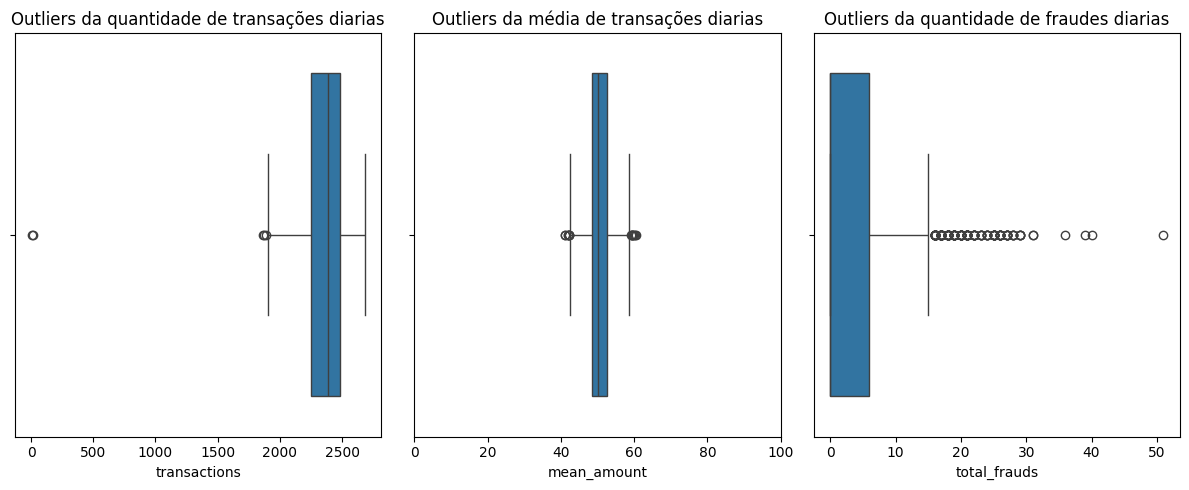

In [17]:
plt.figure(figsize=(12, 5))

plt.subplot(131)
plt.title('Outliers da quantidade de transações diarias')
ax = sns.boxplot(x=df_transactions_day['transactions'])

plt.subplot(132)
plt.title('Outliers da média de transações diarias')
ax = sns.boxplot(x=df_transactions_day['mean_amount'])
ax.set_xlim(0, 100)

plt.subplot(133)
plt.title('Outliers da quantidade de fraudes diarias')
ax = sns.boxplot(x=df_transactions_day['total_frauds'])

plt.tight_layout()
plt.show()

In [18]:
stat, p = stats.shapiro(df_transactions_day['transactions'])

alpha = 0.05

if p > alpha:
    print('A amostra provavelmente segue uma distribuição normal (falha ao rejeitar H0)')
else:
    print('A amostra provavelmente não segue uma distribuição normal (rejeita H0)')

A amostra provavelmente não segue uma distribuição normal (rejeita H0)


In [19]:
min, max = get_outliers(df_transactions_day, 'transactions')
print('Outlier min:', min)
print('Outlier max:', max)

Outlier min: 1891.5
Outlier max: 2839.5


In [20]:
min, max = get_outliers(df_transactions_day, 'mean_amount')
print('Outlier min:', round(min, 2))
print('Outlier max:', round(max, 2))

Outlier min: 42.32
Outlier max: 58.91


In [21]:
min, max = get_outliers(df_transactions_day, 'total_frauds')
print('Outlier min:', round(min, 2))
print('Outlier max:', round(max, 2))

Outlier min: 0
Outlier max: 15.0


Análises

> Quantidade de transações por dia

* A quantidade média de transações por dia é de 2359 transações diárias.
* A média e mediana estão bem próximas, com a média inferior a mediana, indicando uma distribuição assimetrica a esquerda (assimetria negativa).
* A distribuição não segue uma distribuição normal.
* Ha uma concentração muito grande de dias com quantidades entre 1998 e 2980.
* Dias com quantidade de transações menores que 2000 são consideradas outliers em relação ao comportamento da variável.

> Valor médio das transações

* A média das transações é de 43.31
* Existem transações com valores muito maiores acima da média (acima de 600).
* Transações com valores abaixo de 36.67 e acima de 49.23 são considerados outliers.

> Fraudes

* A quantidade média de fraudes por dia, quando ocorre, é de 8.49 e mediana é 7.
* Dias com quantidade de fraude acima de 15.0 são outliers
* 44% dos dias tiveram fraude.

### Análise Mensal

In [22]:
df_time = pd.DataFrame()
df_time['year'] = df['date'].dt.to_period('Y')
df_time['year_month'] = df['date'].dt.to_period('M').dt.to_timestamp(how='start')
df_time['amount'] = df['amount']
df_time['target'] = df['target']
df_time.head()

,year,year_month,amount,target
1,2010,2010-01-01,14.57,No
2,2010,2010-01-01,80.00,No
3,2010,2010-01-01,46.41,No
4,2010,2010-01-01,4.81,No
5,2010,2010-01-01,26.46,No


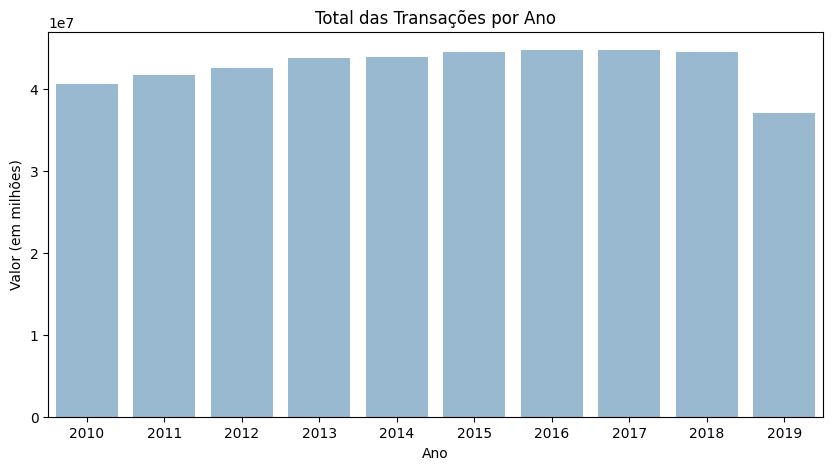

In [23]:
df_time_year = df_time.groupby(['year'])['amount'].sum().reset_index()

plt.subplots(figsize=(10, 5))
plt.title('Total das Transações por Ano')
sns.barplot(data=df_time_year, x='year', y='amount', alpha=0.5)
plt.ylabel('Valor (em milhões)')
plt.xlabel('Ano')

plt.show()

In [24]:
df_time_year = df_time.groupby(['year','target'])['amount'].sum().reset_index()
df_time_year['amount_million'] = df_time_year['amount'] / 1000000
df_time_year.head()

,year,target,amount,amount_million
0,2010,No,40316371.31,40.316371
1,2010,Yes,345612.83,0.345613
2,2011,No,41740903.56,41.740904
3,2011,Yes,5792.40,0.005792
4,2012,No,42508995.71,42.508996


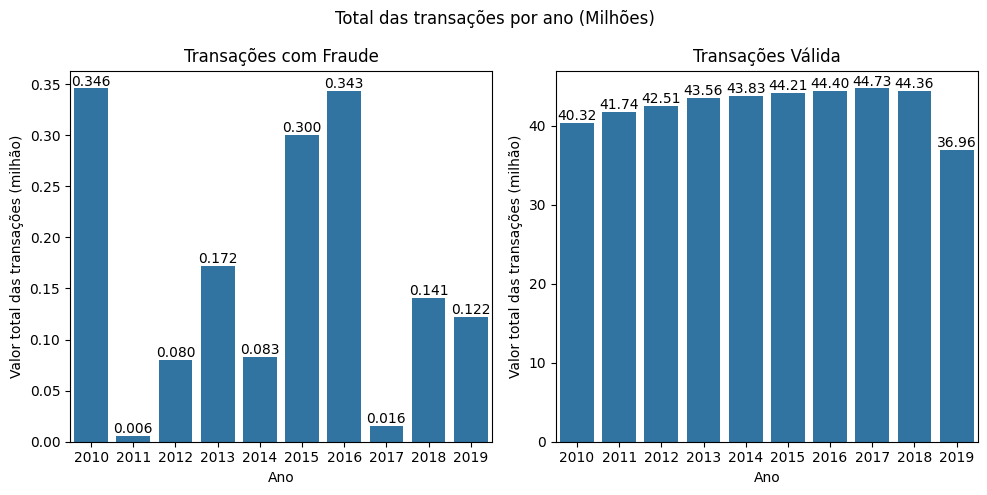

In [25]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title('Transações com Fraude')
ax1 = sns.barplot(data=df_time_year.query('target == "Yes"'), x='year', y='amount_million')
for patches in ax1.patches:
    ax1.annotate(f'{patches.get_height():.3f}', (patches.get_x() + patches.get_width() / 2., patches.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.ylabel('Valor total das transações (milhão)')
plt.xlabel('Ano')

plt.subplot(122)
plt.title('Transações Válida')
ax2 = sns.barplot(data=df_time_year.query('target == "No"'), x='year', y='amount_million')
for patches in ax2.patches:
    ax2.annotate(f'{patches.get_height():.2f}', (patches.get_x() + patches.get_width() / 2., patches.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.ylabel('Valor total das transações (milhão)')
plt.xlabel('Ano')

plt.suptitle('Total das transações por ano (Milhões)')
plt.tight_layout()
plt.show()

del df_time_year

In [26]:
df_time_month = df_time.groupby(by=['year_month', 'target'])['amount'].agg(['sum', 'mean', 'std']).reset_index()
df_time_month['year'] = df_time_month['year_month'].dt.year
df_time_month['month'] = df_time_month['year_month'].dt.month
df_time_month['amount_million'] = df_time_month['sum'] / 1000000
df_time_month.head()

,year_month,target,sum,mean,std,year,month,amount_million
0,2010-01-01,No,3286875.06,51.044774,74.872442,2010,1,3.286875
1,2010-01-01,Yes,13583.57,131.879320,185.236342,2010,1,0.013584
2,2010-02-01,No,3037208.09,51.207312,75.218317,2010,2,3.037208
3,2010-02-01,Yes,36375.11,148.469837,296.801035,2010,2,0.036375
4,2010-03-01,No,3345357.64,51.192961,75.965458,2010,3,3.345358


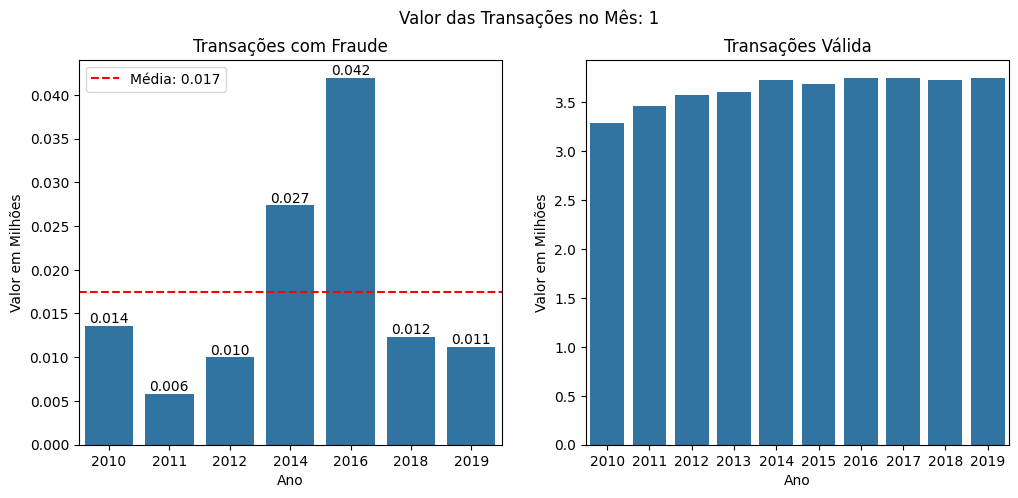

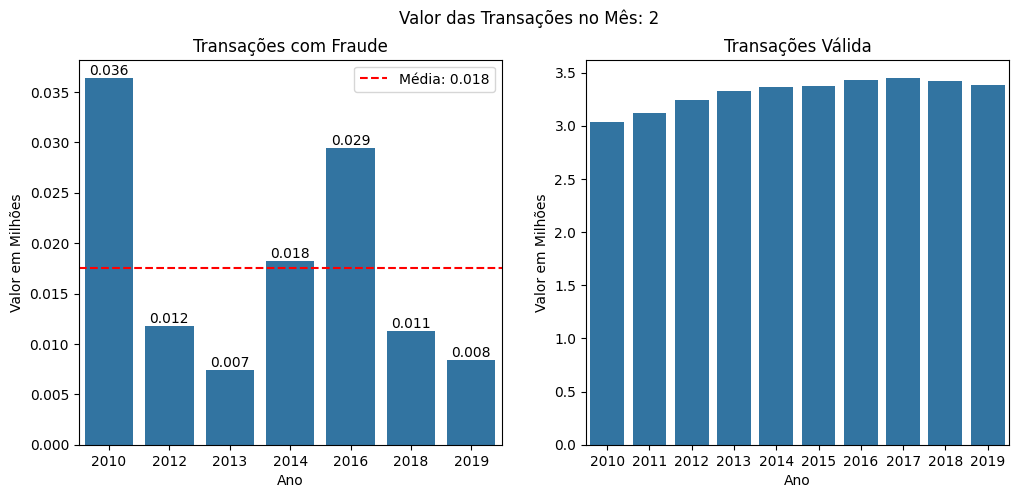

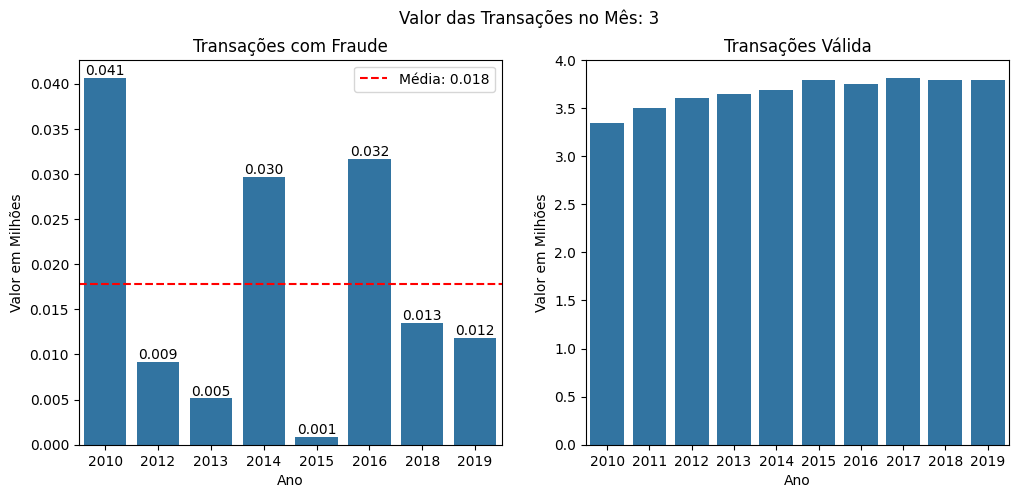

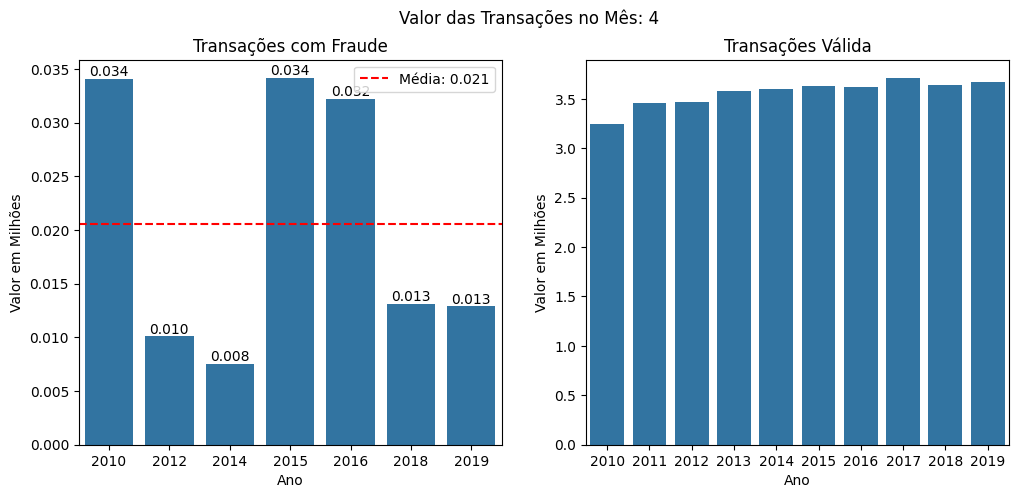

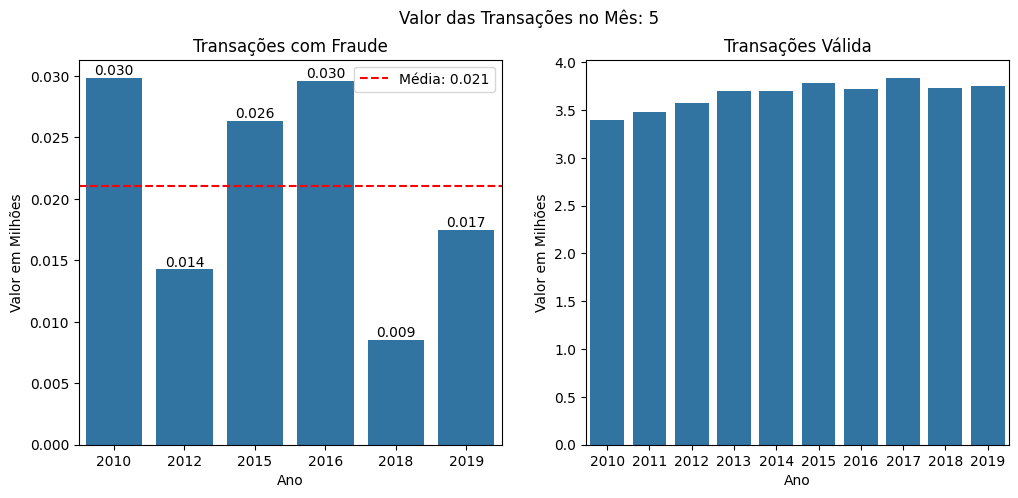

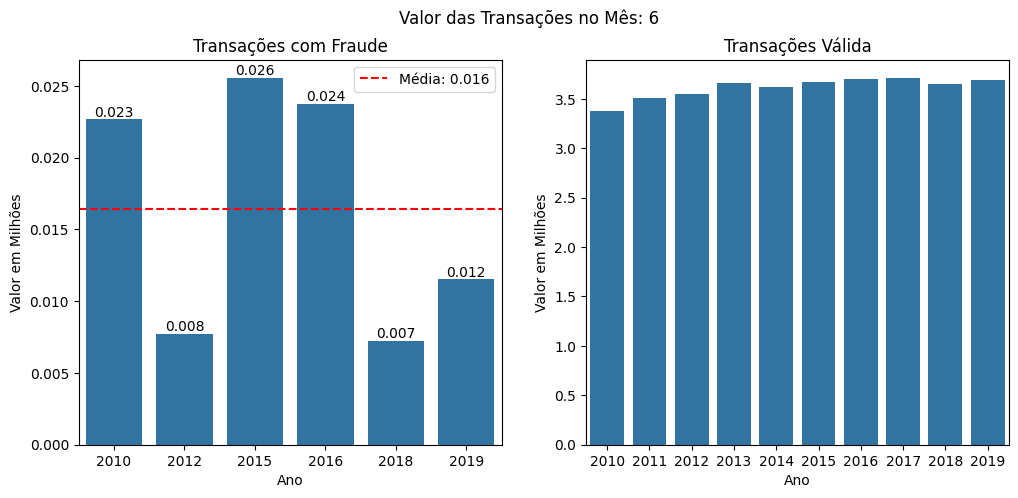

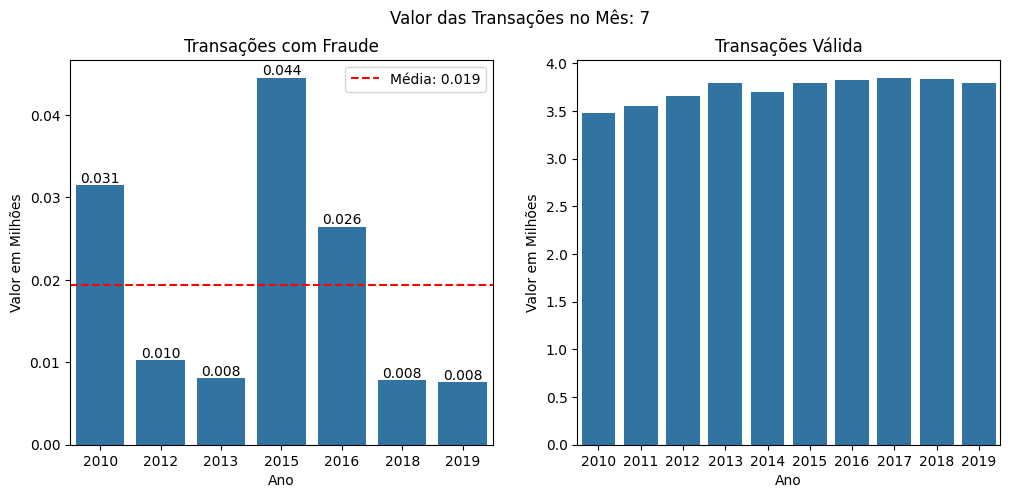

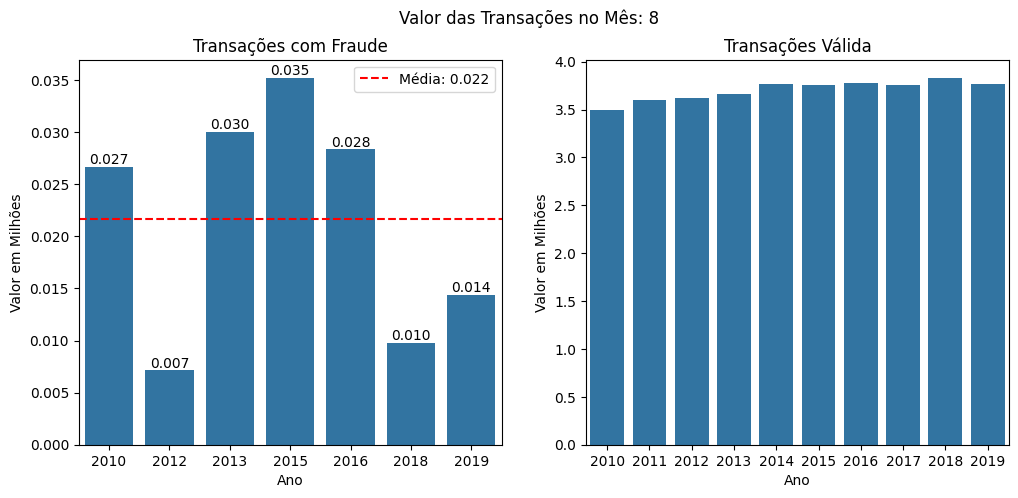

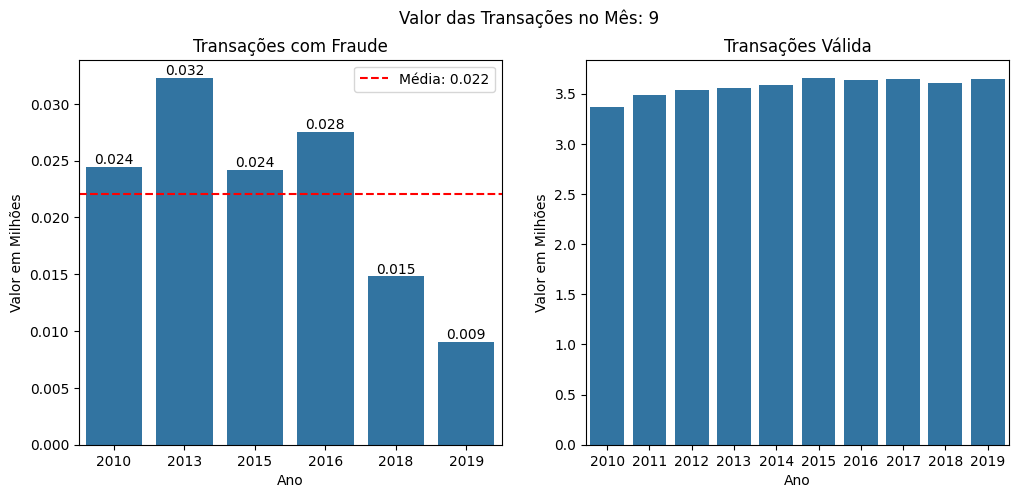

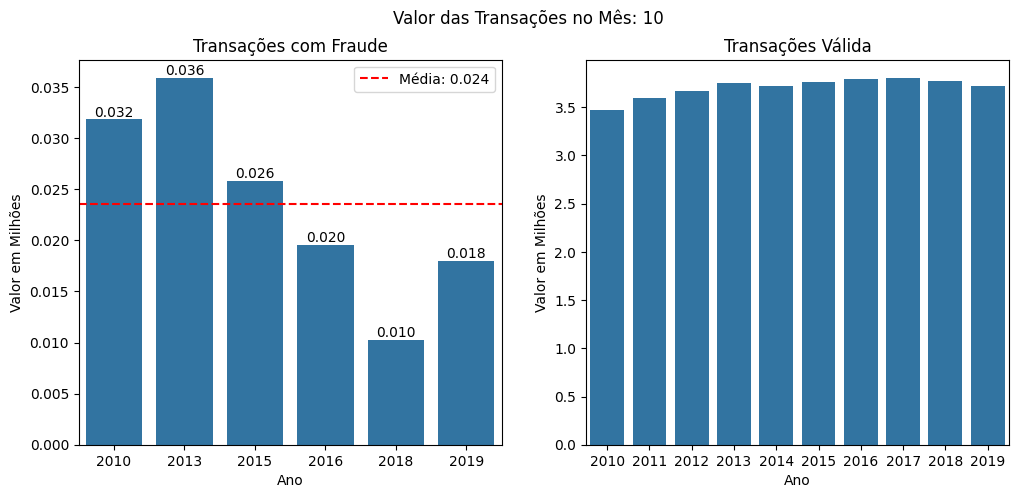

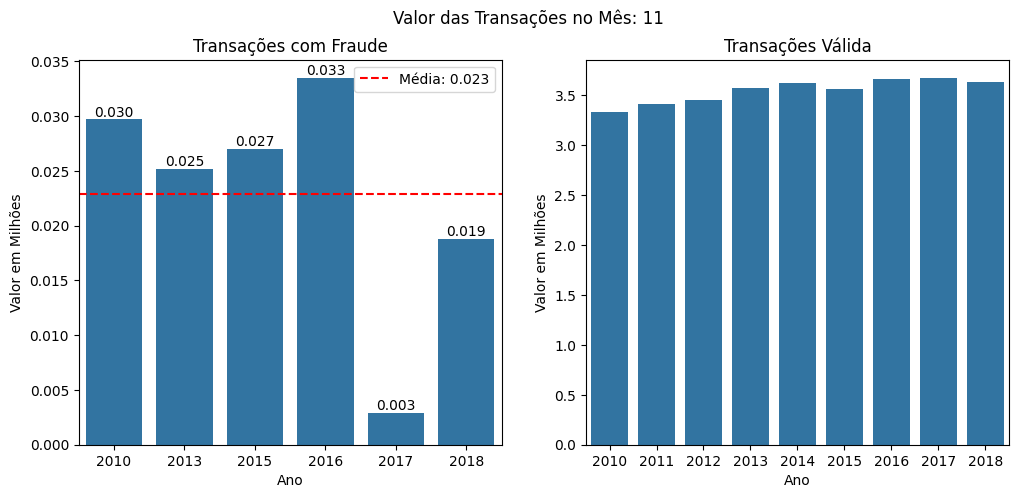

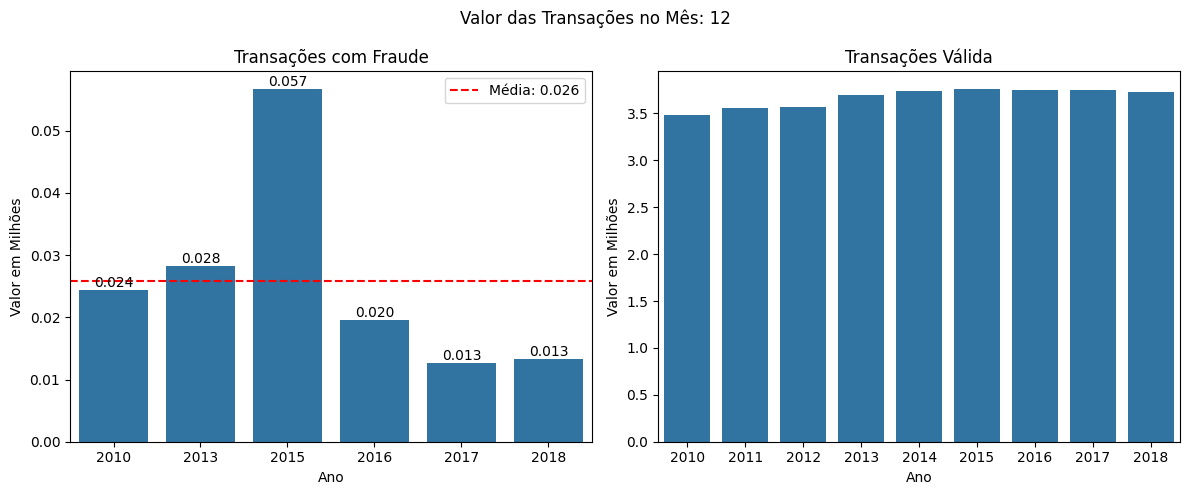

In [27]:
for month in df_time_month['month'].unique():
  df_time_month_month = df_time_month.query('month == @month')

  plt.figure(figsize=(12,5))
  plt.suptitle(f'Valor das Transações no Mês: {month}')

  plt.subplot(121)
  plt.title('Transações com Fraude')

  ax = sns.barplot(data=df_time_month_month.query('target == "Yes"'), x='year', y='amount_million')

  for patches in ax.patches:
    ax.annotate(f'{patches.get_height():.3f}', (patches.get_x() + patches.get_width() / 2., patches.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

  mean = df_time_month_month.query('target == "Yes"')['amount_million'].mean()
  ax.axhline(mean, color='red', linestyle='--', label=f'Média: {mean:.3f}')
  ax.legend()

  plt.ylabel('Valor em Milhões')
  plt.xlabel('Ano')

  plt.subplot(122)
  plt.title('Transações Válida')
  sns.barplot(data=df_time_month_month.query('target == "No"'), x='year', y='amount_million')
  plt.ylabel('Valor em Milhões')
  plt.xlabel('Ano')

plt.tight_layout()
plt.show()

* Dezembro é o mês com maior média de prejuizo nos anos avaliados (24 mil aproximadamente).
* 2016 foi o ano com maior média de fraude nos anos, chegando a 2,62%
* 2015 foi o ano com maior percentual médio de fraude, levando em consideração apenas os meses que ocorreram fraude, chegando a 3,16%

In [28]:
del df_time, df_time_day, df_time_month, df_time_month_month, df_transactions_day

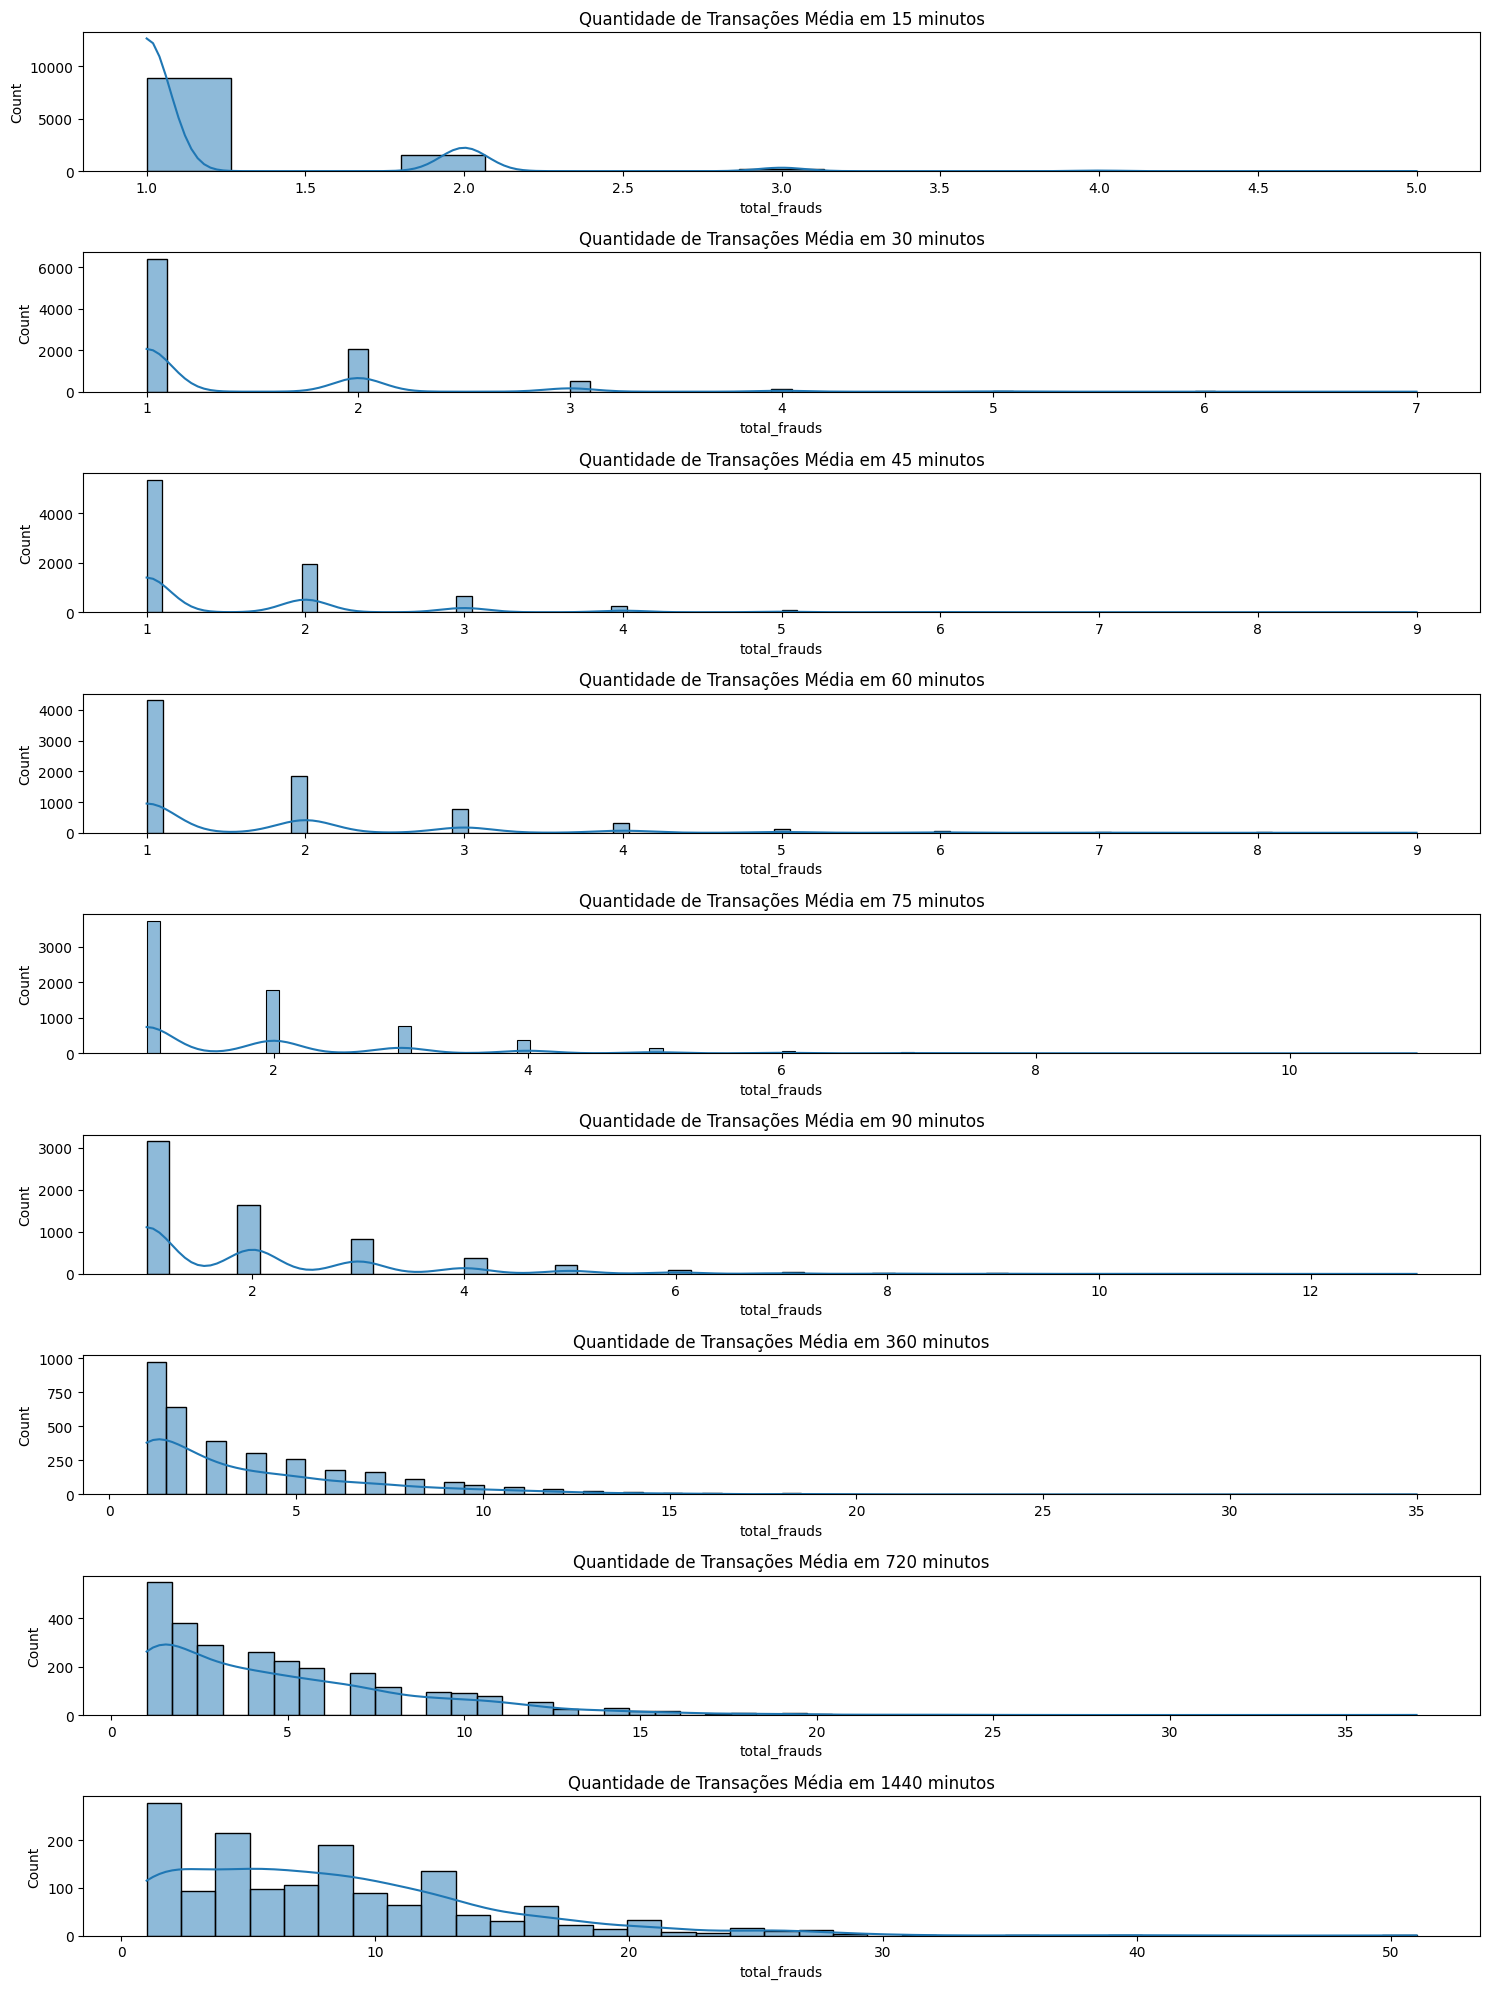

In [29]:
minutes = [15, 30, 45, 60, 75, 90, 360, 720, 1440]
# 15min, 30min, 45min, 1H, 1H15min, 1H30min, 6H, 12H, 24H

plt.figure(figsize=(15, 20))
for i, minute in enumerate(minutes):
  plt.subplot(len(minutes), 1, i+1)
  plt.title(f'Quantidade de Fraudes Média em {minute} minutos')

  df_minutes = pd.DataFrame()
  df_minutes['slide_date'] = df['date'].dt.floor(f'{minute}T')
  df_minutes['target'] = df['target'].apply(lambda x: 1 if x == 'Yes' else 0)

  df_minutes = df_minutes.groupby(by='slide_date').agg({'target': ['sum']}).reset_index()
  df_minutes.columns = ['slide_date', 'total_frauds']

  sns.histplot(df_minutes.query('total_frauds > 0')['total_frauds'], kde=True)

plt.tight_layout()
plt.show()

## Análise Numérica

In [31]:
number_columns = df.select_dtypes(include=['float64', 'int64']).columns
number_columns

Index(['amount', 'current_age', 'retirement_age', 'latitude', 'longitude',
       'per_capita_income', 'yearly_income', 'total_debt', 'credit_score',
       'num_credit_cards', 'num_cards_issued', 'credit_limit',
       'year_pin_last_changed'],
      dtype='object')

In [32]:
df[number_columns].describe()

,amount,current_age,retirement_age,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,num_cards_issued,credit_limit,year_pin_last_changed
count,8.472184e+06,8.472184e+06,8.472184e+06,8.472184e+06,8.472184e+06,8.472184e+06,8.472184e+06,8.472184e+06,8.472184e+06,8.472184e+06,8.472184e+06,8.472184e+06,8.472184e+06
mean,5.054443e+01,5.407888e+01,6.649346e+01,3.736817e+01,-9.151365e+01,2.395606e+04,4.661834e+04,5.780114e+04,7.141209e+02,3.848335e+00,1.520839e+00,1.553141e+04,2.011345e+03
std,7.384986e+01,1.574906e+01,3.577259e+00,5.090949e+00,1.626207e+01,1.187400e+04,2.423906e+04,5.196181e+04,6.571816e+01,1.570767e+00,5.152803e-01,1.218628e+04,2.892089e+00
min,0.000000e+00,2.300000e+01,5.300000e+01,2.130000e+01,-1.581800e+02,0.000000e+00,1.000000e+00,0.000000e+00,4.880000e+02,1.000000e+00,1.000000e+00,0.000000e+00,2.002000e+03
25%,1.104000e+01,4.200000e+01,6.500000e+01,3.389000e+01,-9.734000e+01,1.714000e+04,3.281700e+04,1.643700e+04,6.840000e+02,3.000000e+00,1.000000e+00,8.052000e+03,2.010000e+03
50%,3.188000e+01,5.200000e+01,6.600000e+01,3.835000e+01,-8.644000e+01,2.115900e+04,4.106900e+04,5.163300e+04,7.160000e+02,4.000000e+00,2.000000e+00,1.346100e+04,2.011000e+03
75%,6.631000e+01,6.300000e+01,6.800000e+01,4.112000e+01,-8.008000e+01,2.737600e+04,5.412200e+04,8.494900e+04,7.560000e+02,5.000000e+00,2.000000e+00,2.082700e+04,2.013000e+03
max,6.613440e+03,1.010000e+02,7.900000e+01,4.853000e+01,-6.867000e+01,1.631450e+05,2.801990e+05,4.618540e+05,8.500000e+02,9.000000e+00,3.000000e+00,1.413910e+05,2.020000e+03


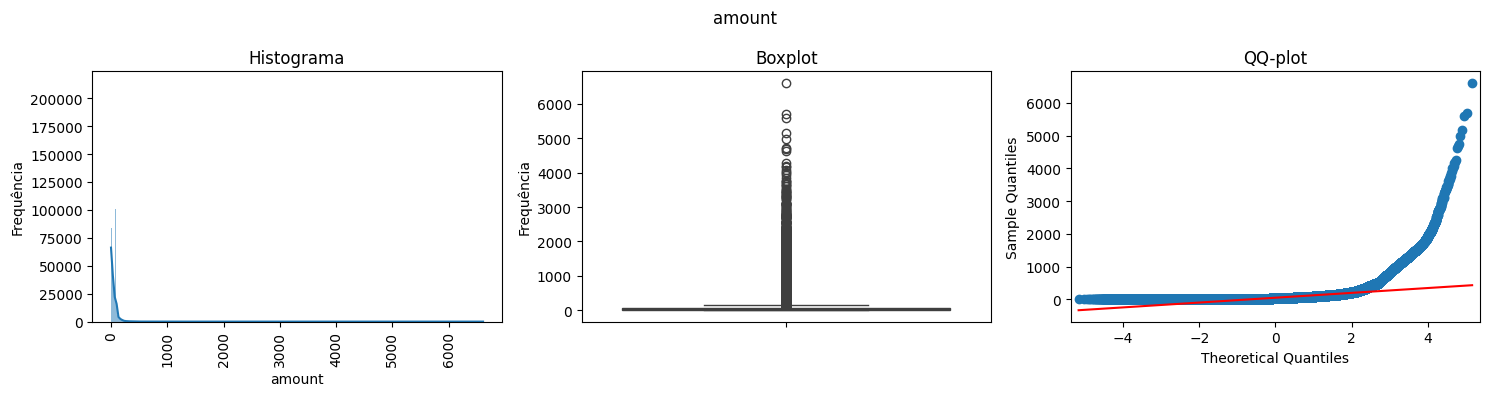

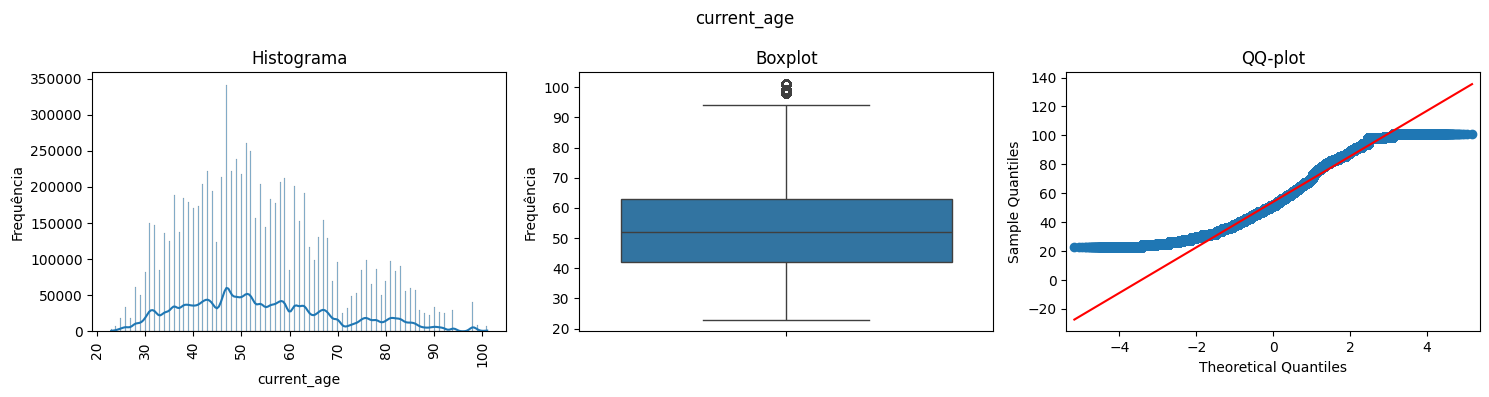

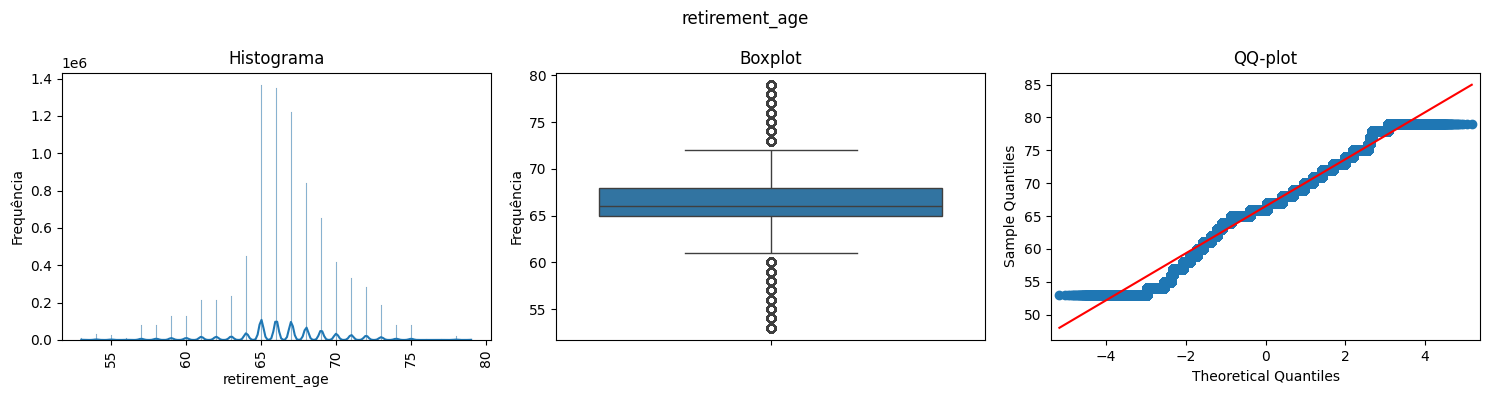

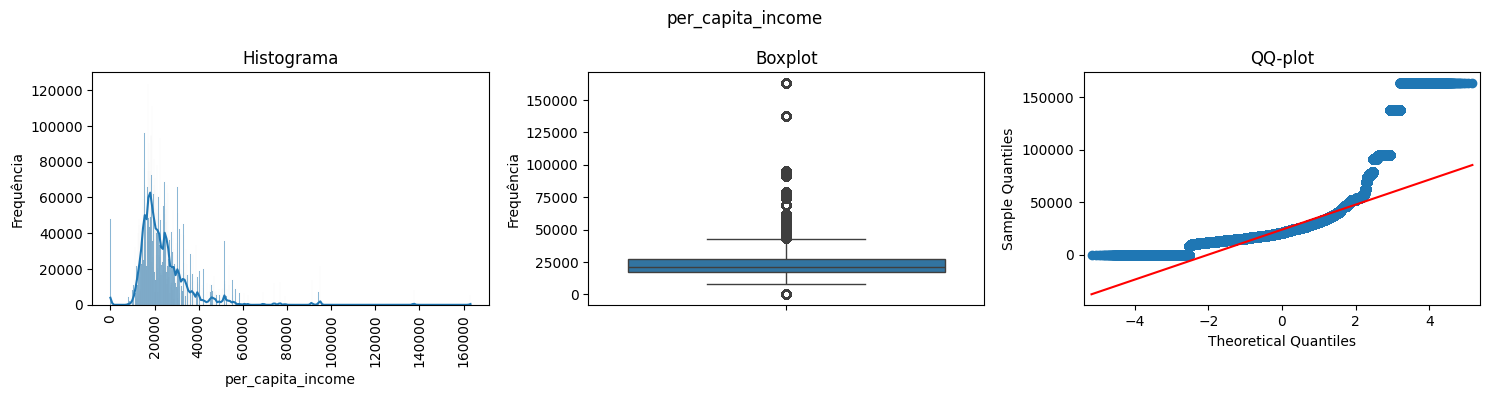

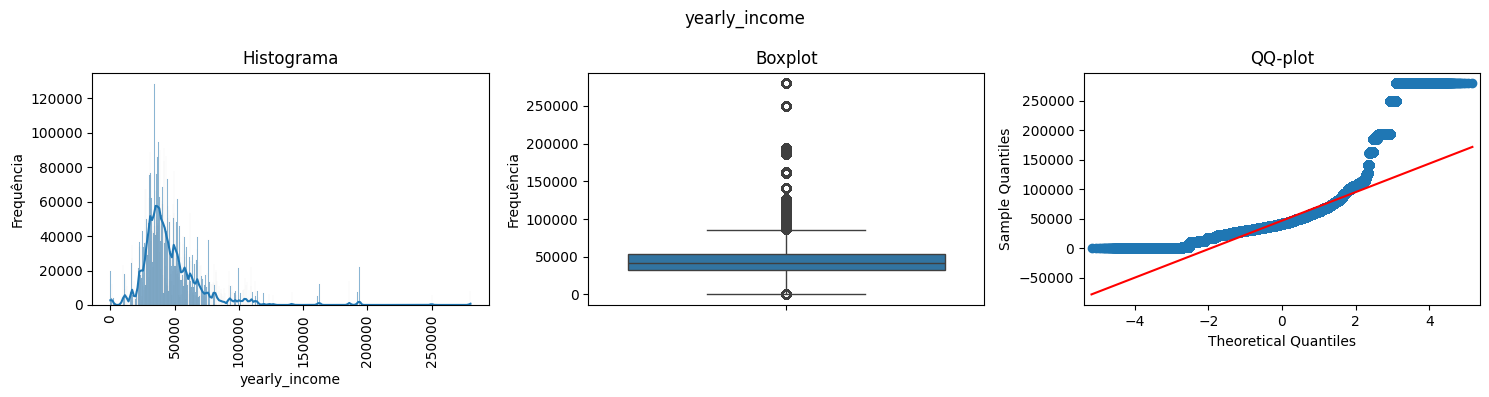

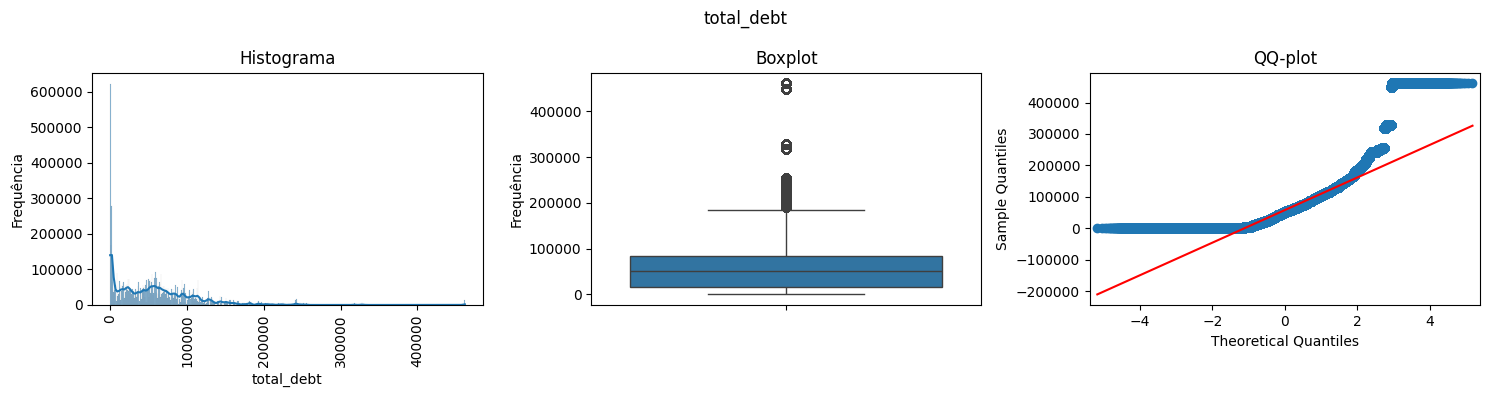

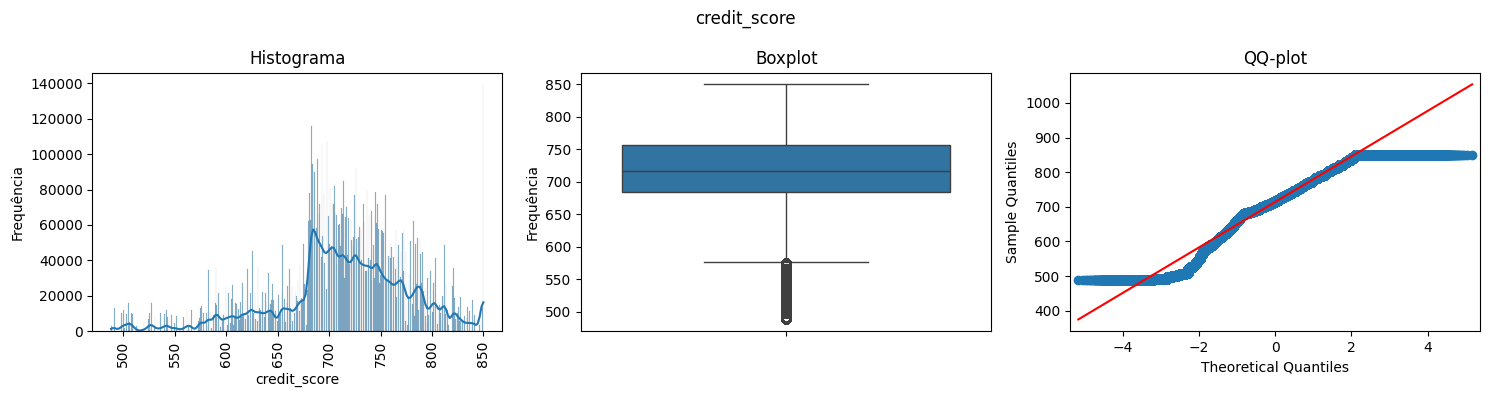

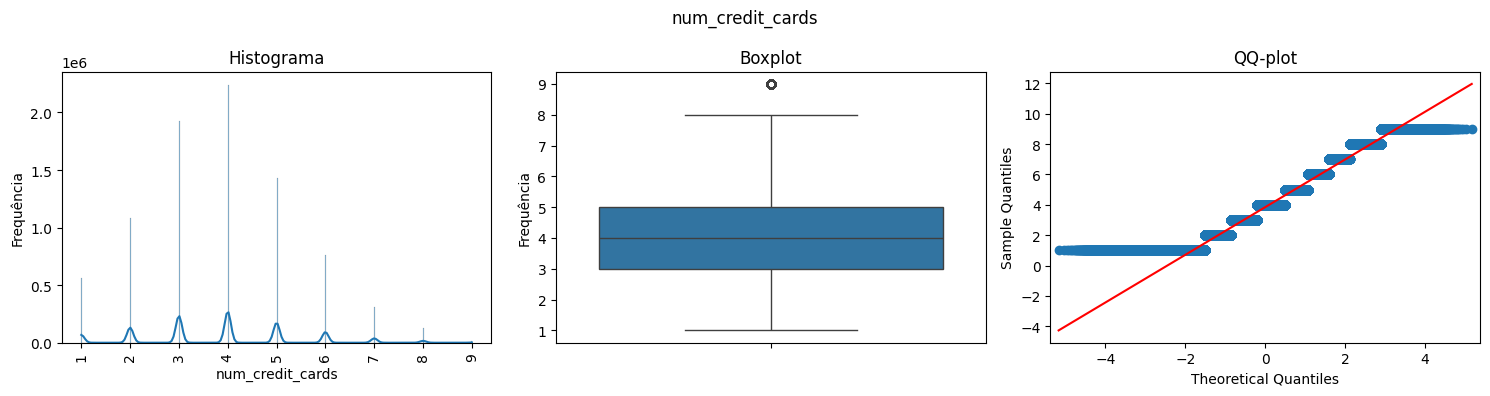

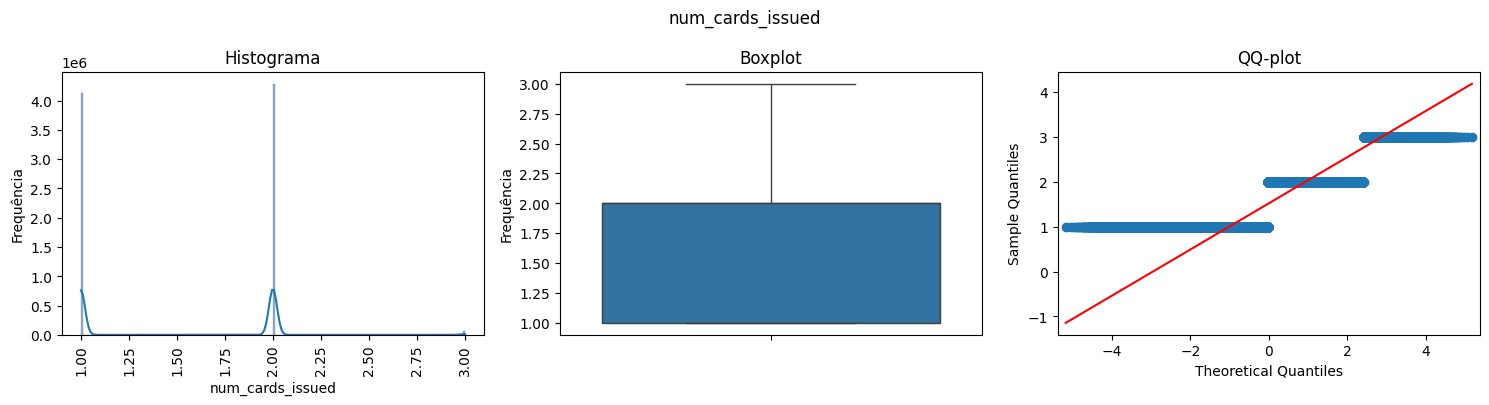

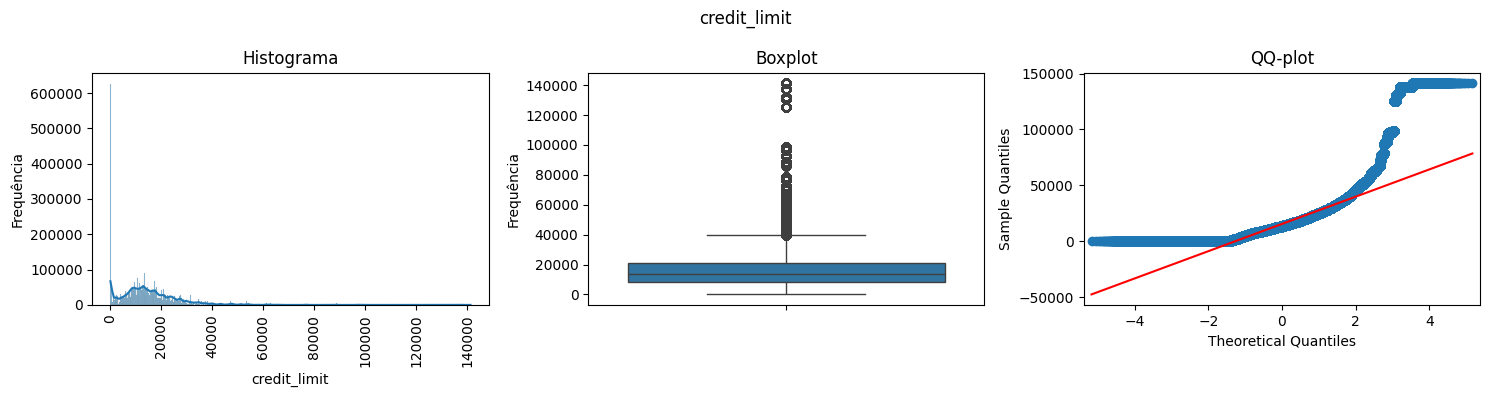

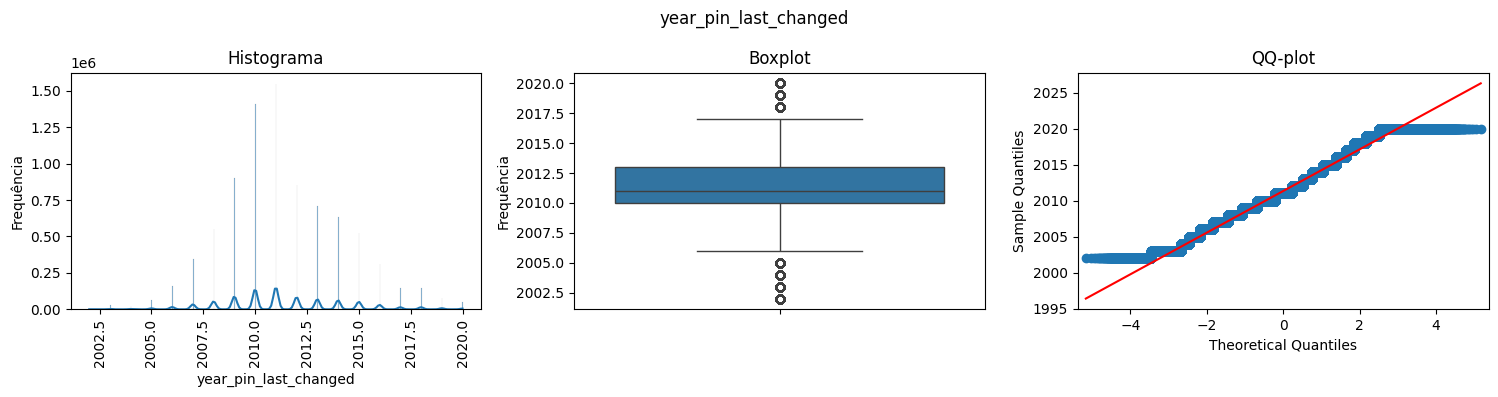

In [33]:
for column in filter(lambda x: x not in ['latitude', 'longitude'], number_columns):
  plot_hist_box(df, column)

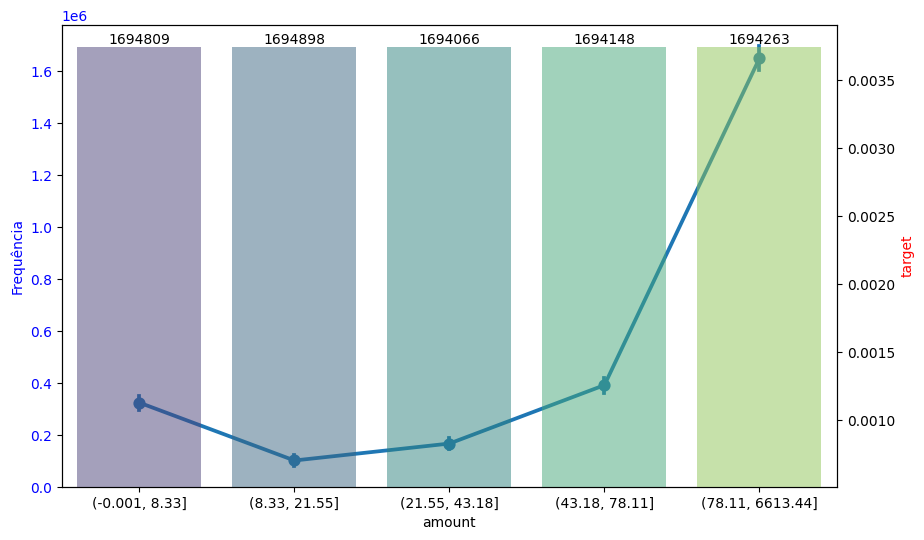

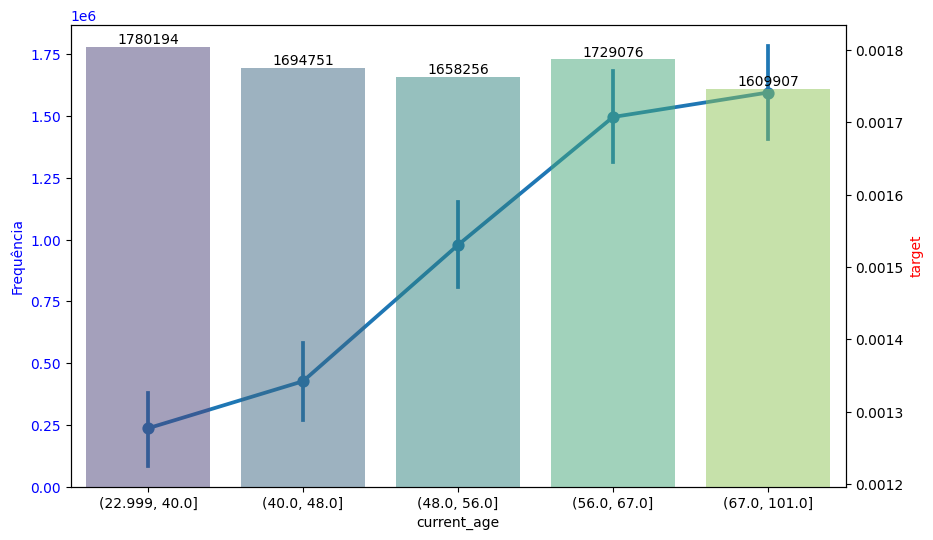

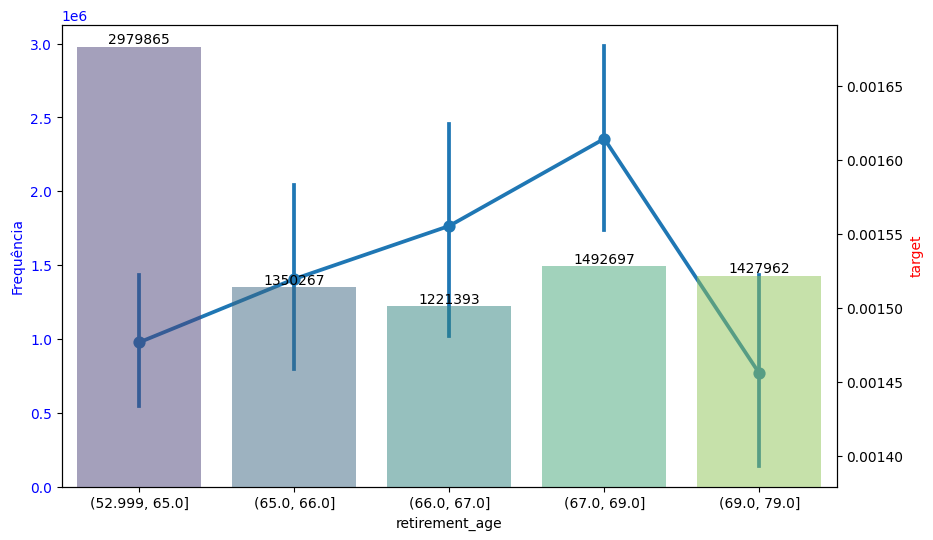

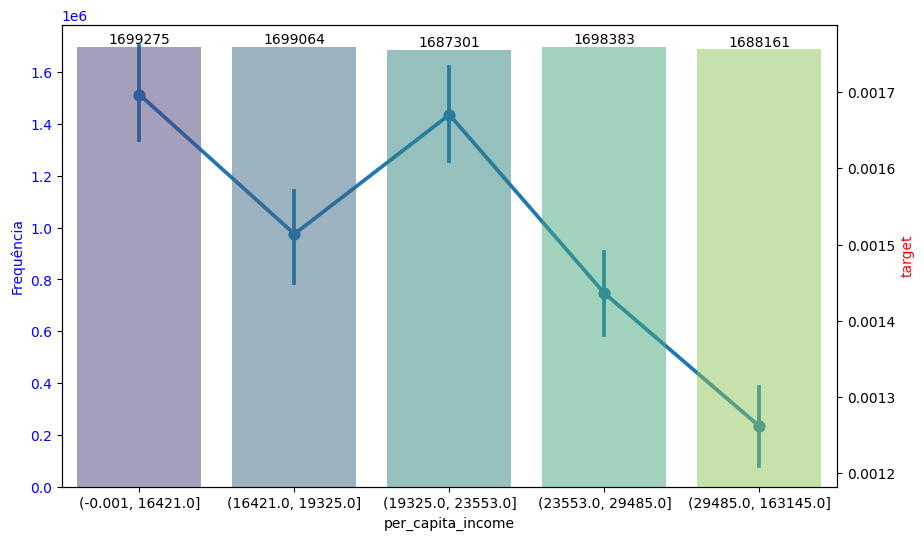

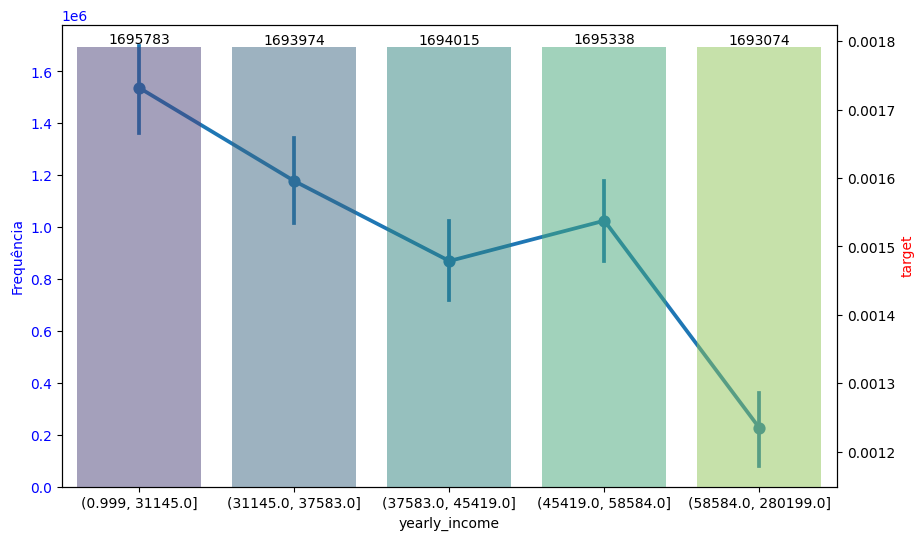

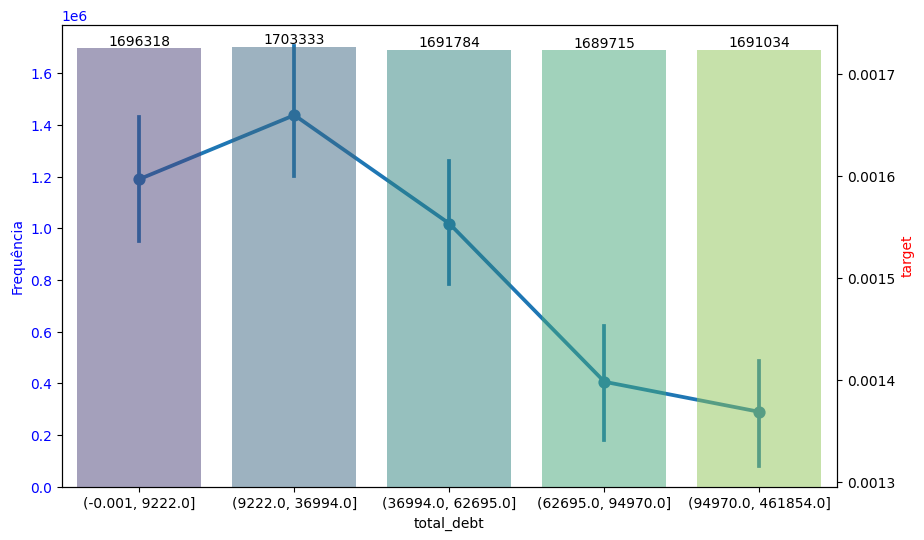

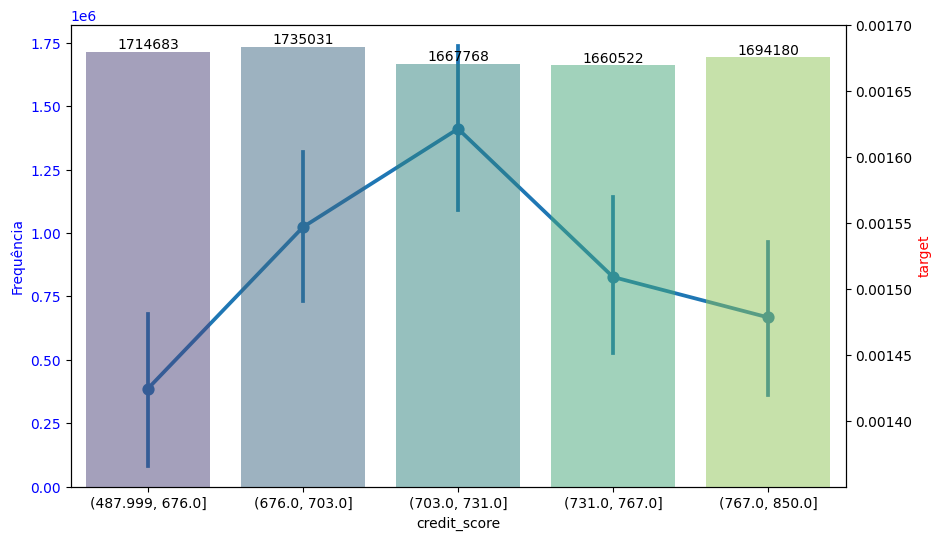

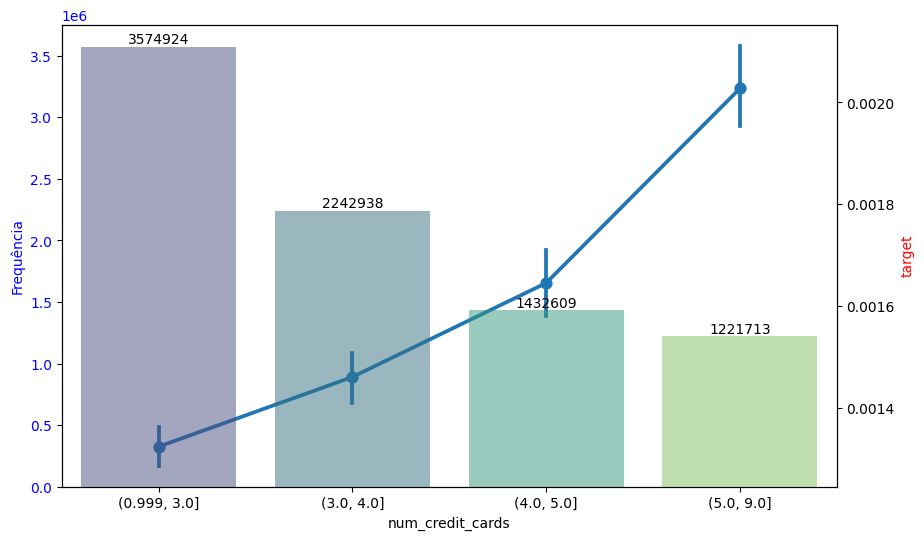

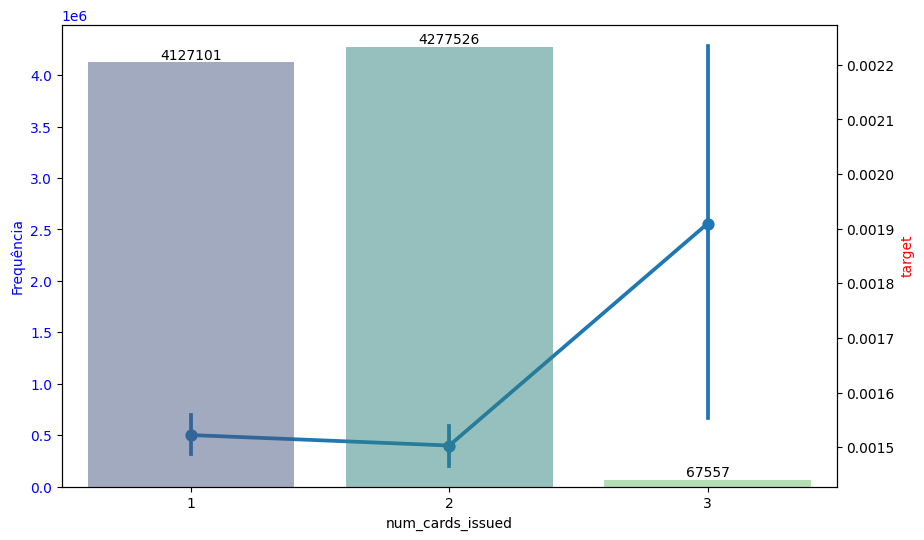

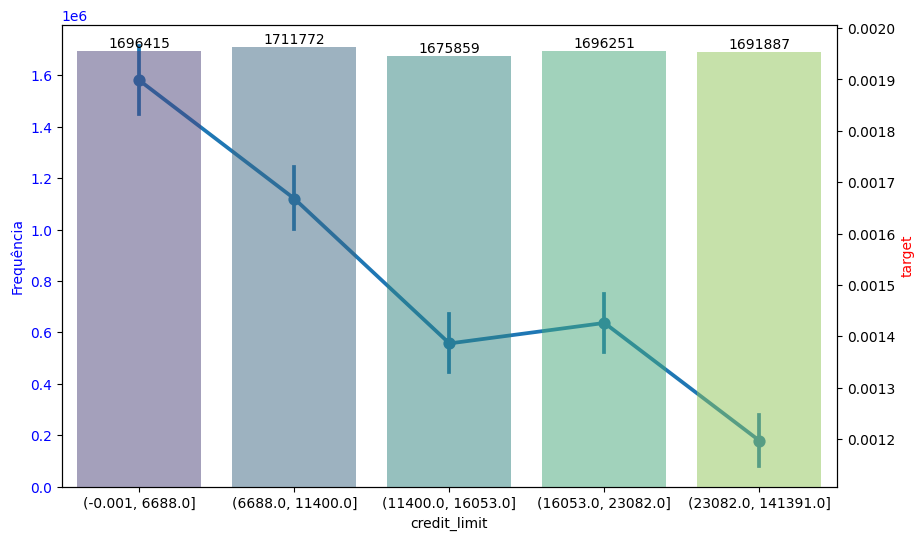

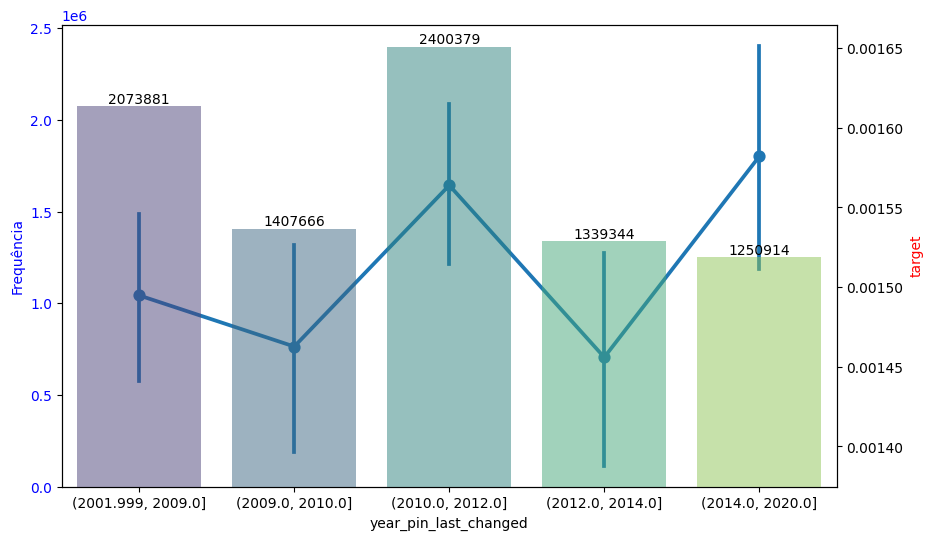

In [34]:
for column in filter(lambda x: x not in ['latitude', 'longitude'], number_columns):
    descritiva(df, column, 'target', map_target={ 'Yes': 1, 'No': 0 })

> amount

* Compras com valor abaixo de 75.51 possui menor indice de fraude

> current_age

* Faixa acima de 56 possui um maior indice de fraude

> retirement_age

* Indice de fraude muito volatil para o as idades de 53 a 79

> per_capita_income

* Indice de fraude maior para as faixas abaixo de 29367

> yearly_income

* Indice de fraude maior para as faixas abaixo de 58503

> total_debit

* Indice de fraude mario para as faixas abaixo de 63019

> credit_score

*

> num_credit_cards

* Clientes com quantidade de cartão acima de 5 cartões tem uma taxa muito maior de indice de fraude

> credit_limit

* Clientes com limite de credito menor (abaixo de 6700) apresentam um maior indice de fraude



In [ ]:
ax = sns.pairplot(df[number_columns].drop(columns=['latitude', 'longitude']))
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
plt.title('Correlação entre as variáveis')

corr = df[number_columns].drop(columns=['latitude', 'longitude']).corr()
sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()

In [ ]:
upper_triangle_indices = np.where(np.abs(np.triu(corr, k=1)) > 0.2)
colunas_indices = np.unique(np.concatenate(upper_triangle_indices))
colunas_filtradas = corr.columns[colunas_indices].tolist()
colunas_filtradas


In [ ]:
plt.figure(figsize=(12,8))
plt.title('Correlação entre as variáveis com maior correlação')

corr = df[colunas_filtradas].corr()
sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()

* Correlação muito alta entre `per_capita_income` e `yearly_income` (0.95) indicando **multicolinearidade**.
* Correlação alta entre `credit_limit` e `per_capita_income` (0.61).
* Correlação alta entre `credit_limit` e `yearly_income` (0.58)

In [ ]:
import plotly.express as px

df_fraude = df[df['target'] == 'Yes']

fig = px.scatter_mapbox(df_fraude,
                        lat="latitude",
                        lon="longitude",
                        hover_name="address",  # Informação ao passar o mouse
                        zoom=1,  # Zoom mínimo para mostrar o mundo
                        height=600)          # Altura do mapa

# Define o estilo do mapa (opcional)
fig.update_layout(mapbox_style="open-street-map")

# Ajustando as configurações geográficas para mostrar o mapa completo
fig.update_layout(
    title='Fraude com base na localização do cliente',
    geo=dict(
        scope='world',
        showland=True,
        landcolor="lightgray",
        showocean=True,
        oceancolor="lightblue",
        projection_type='natural earth'
    )
)

fig.show()
fig.write_html('fraude_map.html')
del df_fraude

A maioria das fraudes ocorreram nos E.U.A

## Análise Categorica

In [ ]:
categorical_columns = df.drop(columns=['id', 'client_id', 'merchant_id', 'card_id']).select_dtypes(include=['object']).columns.tolist()
categorical_columns

In [ ]:
df[categorical_columns].describe().T

In [ ]:
top = 30
for column in categorical_columns:
  if column == 'target':
    continue

  plt.figure(figsize=(12,8))

  df_target = df.groupby(by=[column])['target'].value_counts(normalize=True).reset_index().query('target == "Yes"').drop(columns=['target'])
  df_target.columns = [column, 'percent']
  df_target = pd.merge(df[column].value_counts().reset_index(), df_target, on=column, how='left').fillna(0)

  title = f'Contagem de {column}'
  if len(df_target) > top:
    title = f'Contagem dos top {top} {column}'
    df_target = df_target.iloc[0:top]

  plt.title(title)
  ax = sns.barplot(data=df_target, x=column, y='count', alpha=0.5)
  ax.set_ylabel('Quantidade')
  ax.set_xlabel(column)
  ax.tick_params(axis='x', rotation=90)

  # for container in ax.containers:
  #   ax.bar_label(container, fmt='%d', label_type='edge', padding=5)

  ax2 = ax.twinx()
  ax2 = sns.pointplot(data=df_target, x=column, y='percent', ax=ax2)
  ax2.set_ylabel('% Fraude')

  ax.set_zorder(2)
  ax.patch.set_visible(False)

  plt.grid(True)
  plt.show()
  del df_target

* Transações feitas e pagas online são as que possuem maior taxa de fraude
* Falhas com o digito incorreto do CVV são os que maior precedem trasações com fraude
* Mulheres apresentam maior taxa de fraude em relação aos homens
* Cartões da Discovery possuem uma maior taxa de transações fraudadas

In [ ]:
df['merchant_state'].unique()

In [ ]:
df_cat = pd.DataFrame()
df_cat['use_chip'] = df['use_chip']
df_cat['online_sales'] = df['merchant_city'].apply(lambda x: 'Yes' if str(x).lower() == 'online' else 'No')
df_cat['city'] = df['merchant_city'].apply(lambda x: 'Online' if str(x).lower() == 'online' else x)
df_cat['country'] = df['merchant_state'].apply(lambda x: 'United States' if x and len(x) == 2 else x)
df_cat['category'] = df['description']
df_cat['gender'] = df['gender']
df_cat['card_brand'] = df['card_brand']
df_cat['card_type'] = df['card_type']
df_cat['card_expires'] = df['expires']
df_cat['card_has_chip'] = df['has_chip'].apply(lambda x: 'Yes' if x == 'YES' else 'No')
df_cat['card_payment'] = df_cat['use_chip']
df_cat['target'] = df['target']
df_cat.head()

# Fórmulas: Teste Qui-Quadrado e V de Cramer

Fórmulas para o teste Qui-Quadrado de Independência e a Medida de Associação V de Cramer.

## Teste Qui-Quadrado de Independência

O teste Qui-Quadrado ($\chi^2$) é utilizado para determinar se existe uma associação estatisticamente significativa entre duas ou mais variáveis categóricas. A fórmula para a estatística Qui-Quadrado é:

$$\chi^2 = \sum_{i=1}^{r} \sum_{j=1}^{c} \frac{(O_{ij} - E_{ij})^2}{E_{ij}}$$

Onde:

* $\chi^2$ = Estatística Qui-Quadrado
* $\sum$ = Símbolo de somatório (soma sobre todas as células da tabela)
* $r$ = Número de linhas na tabela de contingência
* $c$ = Número de colunas na tabela de contingência
* $O_{ij}$ = Frequência observada na célula da linha $i$ e coluna $j$
* $E_{ij}$ = Frequência esperada na célula da linha $i$ e coluna $j$, calculada como:

    $$E_{ij} = \frac{(\text{Total da Linha } i) \times (\text{Total da Coluna } j)}{\text{Total Geral de Observações}}$$

Os graus de liberdade (gl) para o teste Qui-Quadrado em uma tabela de contingência $r \times c$ são calculados como:

$$gl = (r - 1) \times (c - 1)$$

O p-valor associado à estatística Qui-Quadrado é então utilizado para determinar a significância estatística da associação. Um p-valor baixo (tipicamente < 0.05) sugere que há evidências suficientes para rejeitar a hipótese nula de independência entre as variáveis.

## V de Cramer

O V de Cramer (às vezes denotado como $\phi_C$) é uma medida de associação entre duas variáveis categóricas nominais. É uma normalização da estatística Qui-Quadrado que fornece um valor entre 0 e 1, indicando a força da associação. A fórmula para o V de Cramer é:

$$V = \sqrt{\frac{\chi^2}{n \times \min(k-1, r-1)}}$$

Onde:

* $V$ = V de Cramer
* $\chi^2$ = Estatística Qui-Quadrado obtida do teste de independência
* $n$ = Número total de observações na tabela de contingência
* $k$ = Número de colunas na tabela de contingência
* $r$ = Número de linhas na tabela de contingência
* $\min(k-1, r-1)$ = O menor valor entre os graus de liberdade da variável de coluna ($k-1$) e os graus de liberdade da variável de linha ($r-1$)

**Interpretação do V de Cramer:**

* Próximo de 0: Associação fraca ou inexistente.
* Próximo de 1: Associação forte.

Não existem limites rígidos para a interpretação, mas algumas diretrizes comuns incluem:

* 0.0 - 0.1: Associação desprezível
* 0.1 - 0.3: Associação fraca
* 0.3 - 0.5: Associação moderada
* \> 0.5: Associação forte

O V de Cramer é útil para comparar a força da associação entre diferentes pares de variáveis, mesmo que as tabelas de contingência tenham dimensões diferentes.

In [ ]:
P_VALUE = 0.05
V_VALUE = 0.1
selected_columns = ['target']

for column in df_cat.query('target == "Yes"').columns:
  if column == 'target':
    continue

  cross_table = pd.crosstab(df_cat[column], df_cat['target'])
  test_chi2 = stats.chi2_contingency(cross_table)

  n = np.sum(cross_table.values)
  min_dim = np.min(cross_table.values.shape) - 1

  V = np.sqrt((test_chi2[0] / n) / min_dim) if min_dim > 0 else np.nan

  print(f"{column} x target")
  print(f"estatística qui²: {round(test_chi2[0], 2)}")
  print(f"p-valor da estatística: {round(test_chi2[1], 4)}")
  print(f"graus de liberdade: {test_chi2[2]}")
  print(f"estatística V: {round(V, 2)}")
  print('')

  if test_chi2[1] < P_VALUE and V >= V_VALUE:
    selected_columns.append(column)

print(selected_columns)

In [ ]:
mca = prince.MCA(n_components=2)
mca.fit(df_cat.query('target == "Yes"')[selected_columns])

In [ ]:
coord_padrao = mca.column_coordinates(df_cat.query('target == "Yes"')[selected_columns])/np.sqrt(mca.eigenvalues_)
chart = coord_padrao.reset_index()

In [ ]:
chart

In [ ]:
var_chart = pd.Series(chart['index'].str.split('_', expand=True).iloc[:,0])
var_chart

In [ ]:
var_category = pd.Series(chart['index'].str.split('_', expand=True).iloc[:,-1])
var_category

In [ ]:
chart_df_mca = pd.DataFrame({
    'categoria': chart['index'], # Parece ser o índice original do output MCA
    'obs_x': chart[0],          # Coordenada X do output MCA
    'obs_y': chart[1],          # Coordenada Y do output MCA
    'variavel': var_chart,      # Nome da variável associada ao ponto
    'categoria_id': var_category # O nome da categoria para rotulagem (alinhado por índice)
})

In [ ]:
chart_df_mca

In [ ]:
quant_dim = mca.J_ - mca.K_
print(f'Quantidade de dimensões: {quant_dim}')

In [ ]:
print('Média de Inércia principal total por dimensão')
print(mca.total_inertia_/quant_dim)

In [ ]:
plt.figure(figsize=(14, 10))
sns.scatterplot(data=chart_df_mca,
                x='obs_x',
                y='obs_y',
                hue='variavel', # Usa a coluna 'variavel' para determinar a cor dos pontos
                s=100)          # Tamanho dos pontos (ajuste conforme preferir)

# --- Parte 3: Adicionar os rótulos de texto (Equivalente ao argumento 'text' do Plotly) ---
# Iterar sobre cada ponto no DataFrame para adicionar o texto
for i in range(len(chart_df_mca)):
    plt.text(x=chart_df_mca['obs_x'][i] + 0.05, # Posição X do texto (ajuste o offset + 0.05)
             y=chart_df_mca['obs_y'][i] + 0.05, # Posição Y do texto (ajuste o offset + 0.05)
             s=chart_df_mca['categoria_id'][i], # O texto a ser exibido
             fontdict=dict(color='black', size=9)) # Dicionário para configurar a fonte

# Adicionar título e rótulos dos eixos (opcional, mas boa prática)
plt.title('Gráfico de Dispersão das Coordenadas MCA')
plt.xlabel('Coordenada Principal 1')
plt.ylabel('Coordenada Principal 2')

# Adicionar uma grade para melhor visualização
plt.grid(True, linestyle='--', alpha=0.6)

# Mostrar a legenda (seaborn.scatterplot adiciona a legenda automaticamente com 'hue')
plt.legend(title='Variável')

# Ajustar o layout para evitar que rótulos se sobreponham, se possível
plt.tight_layout()

# Mostrar o gráfico
plt.show()


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
inertia = []
# Define um intervalo de números de clusters para testar (ex: de 1 a 10)
# Ajuste o range_n_clusters conforme a sua necessidade e o tamanho dos seus dados
range_n_clusters = range(2, 20)

for n in range_n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
    kmeans.fit(X_mca)
    inertia.append(kmeans.inertia_)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Método do Cotovelo (Elbow Method)')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia (WCSS)')
plt.xticks(range_n_clusters) # Garante que todos os números de clusters testados apareçam no eixo X
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
silhouette_scores = []
# Define um intervalo de números de clusters para testar (ex: de 2 a 10)
# Ajuste o range_n_clusters_silhouette conforme a sua necessidade
range_n_clusters_silhouette = range(2, 20)

for n in range_n_clusters_silhouette:
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
    kmeans.fit(X_mca)
    score = silhouette_score(X_mca, kmeans.labels_) # Calcula o coeficiente de silhueta médio
    silhouette_scores.append(score)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters_silhouette, silhouette_scores, marker='o')
plt.title('Coeficiente de Silhueta (Silhouette Score)')
plt.xlabel('Número de Clusters')
plt.ylabel('Coeficiente de Silhueta Médio')
plt.xticks(range_n_clusters_silhouette) # Garante que todos os números de clusters testados apareçam no eixo X
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
def plot_cluster(data, cluster_columns, n_clusters, x_column, y_column, label_column, title, x_label, y_label):

  values = data[cluster_columns]

  kmeans_mca = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)  # n_init para evitar warnings
  kmeans_mca.fit(values)

  # Change 1: use values instead of kmeans
  labels = kmeans_mca.labels_
  centroids = kmeans_mca.cluster_centers_

  data['cluster'] = labels

  plt.figure(figsize=(14, 10))  # Tamanho da figura

  # --- Início: Plotagem das Áreas de Decisão (Decision Boundaries) ---
  # Cria um meshgrid para cobrir a área do gráfico
  # Change 2: Access values using .iloc[] for integer-based indexing
  x_min_values, x_max_values = values.iloc[:, 0].min() - 0.1, values.iloc[:, 0].max() + 0.1
  y_min_values, y_max_values = values.iloc[:, 1].min() - 0.1, values.iloc[:, 1].max() + 0.1

  xx_values, yy_values = np.meshgrid(np.arange(x_min_values, x_max_values, 0.01),
                                    np.arange(y_min_values, y_max_values, 0.01))

  # Prediz o cluster para cada ponto no meshgrid
  Z_values = kmeans_mca.predict(np.c_[xx_values.ravel(), yy_values.ravel()])
  Z_values = Z_values.reshape(xx_values.shape)

  cmap_clusters = plt.cm.get_cmap('viridis', n_clusters)

  # Change 3: use xx_values, yy_values, Z_values instead of xx_mca, yy_mca, Z_mca
  plt.contourf(xx_values, yy_values, Z_values, alpha=0.3, cmap=cmap_clusters)

  sns.scatterplot(data=data,
                  x=x_column,
                  y=y_column,
                  hue='cluster',
                  palette=cmap_clusters,
                  s=100,
                  legend='full')

  plt.scatter(centroids[:, 0], centroids[:, 1],
              marker='X',
              s=250,
              color='red',
              label='Centróides dos Clusters',
              edgecolors='black',
              zorder=5)

  for i in range(len(data)):
    plt.text(x=data[x_column].iloc[i] + 0.05, # Posição X do texto (ajuste o offset)
             y=data[y_column].iloc[i] + 0.05, # Posição Y do texto (ajuste o offset)
             s=data[label_column].iloc[i], # O texto a ser exibido
             fontdict=dict(color='black', size=9), # Dicionário para configurar a fonte
             zorder=10)

  plt.title(title)
  plt.xlabel(x_label)
  # Change 4: use y_label instead of t_label
  plt.ylabel(y_label)

  plt.grid(True, linestyle='--', alpha=0.6)

  plt.tight_layout()

  plt.show()

In [ ]:
plot_cluster(data=chart_df_mca, cluster_columns=['obs_x', 'obs_y'], n_clusters=3, x_column='obs_x', y_column='obs_y', label_column='categoria_id', title='Gráfico de Dispersão das Coordenadas MCA para  (3 Clusters)', x_label='Coordenada Principal 1', y_label='Coordenada Principal 2')

In [ ]:
chart_df_mca['variavel'].value_counts()

In [ ]:
categorias = chart_df_mca.query('variavel == "category"')
X_mca = categorias[['obs_x', 'obs_y']].values
categorias

In [ ]:
inertia = []
# Define um intervalo de números de clusters para testar (ex: de 1 a 10)
# Ajuste o range_n_clusters conforme a sua necessidade e o tamanho dos seus dados
range_n_clusters = range(2, 20)

for n in range_n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
    kmeans.fit(X_mca)
    inertia.append(kmeans.inertia_)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Método do Cotovelo (Elbow Method) - Category')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia (WCSS)')
plt.xticks(range_n_clusters) # Garante que todos os números de clusters testados apareçam no eixo X
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
silhouette_scores = []
# Define um intervalo de números de clusters para testar (ex: de 2 a 10)
# Ajuste o range_n_clusters_silhouette conforme a sua necessidade
range_n_clusters_silhouette = range(2, 20)

for n in range_n_clusters_silhouette:
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
    kmeans.fit(X_mca)
    score = silhouette_score(X_mca, kmeans.labels_) # Calcula o coeficiente de silhueta médio
    silhouette_scores.append(score)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters_silhouette, silhouette_scores, marker='o')
plt.title('Coeficiente de Silhueta (Silhouette Score) - Category')
plt.xlabel('Número de Clusters')
plt.ylabel('Coeficiente de Silhueta Médio')
plt.xticks(range_n_clusters_silhouette) # Garante que todos os números de clusters testados apareçam no eixo X
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
plot_cluster(data=categorias, cluster_columns=['obs_x', 'obs_y'], n_clusters=4, x_column='obs_x', y_column='obs_y', label_column='categoria_id', title='Gráfico de Dispersão das Coordenadas MCA - Category', x_label='Coordenada Principal 1', y_label='Coordenada Principal 2')

In [ ]:
cidades = chart_df_mca.query('variavel == "city"')
X_mca = cidades[['obs_x', 'obs_y']].values
cidades

In [ ]:
inertia = []
# Define um intervalo de números de clusters para testar (ex: de 1 a 10)
# Ajuste o range_n_clusters conforme a sua necessidade e o tamanho dos seus dados
range_n_clusters = range(2, 20)

for n in range_n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
    kmeans.fit(X_mca)
    inertia.append(kmeans.inertia_)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Método do Cotovelo (Elbow Method) - City')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia (WCSS)')
plt.xticks(range_n_clusters) # Garante que todos os números de clusters testados apareçam no eixo X
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
silhouette_scores = []
# Define um intervalo de números de clusters para testar (ex: de 2 a 10)
# Ajuste o range_n_clusters_silhouette conforme a sua necessidade
range_n_clusters_silhouette = range(2, 20)

for n in range_n_clusters_silhouette:
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
    kmeans.fit(X_mca)
    score = silhouette_score(X_mca, kmeans.labels_) # Calcula o coeficiente de silhueta médio
    silhouette_scores.append(score)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters_silhouette, silhouette_scores, marker='o')
plt.title('Coeficiente de Silhueta (Silhouette Score) - City')
plt.xlabel('Número de Clusters')
plt.ylabel('Coeficiente de Silhueta Médio')
plt.xticks(range_n_clusters_silhouette) # Garante que todos os números de clusters testados apareçam no eixo X
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
plot_cluster(data=cidades, cluster_columns=['obs_x', 'obs_y'], n_clusters=3, x_column='obs_x', y_column='obs_y', label_column='categoria_id', title='Gráfico de Dispersão das Coordenadas MCA - City', x_label='Coordenada Principal 1', y_label='Coordenada Principal 2')